### prereq

In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import storage
from torchvision import datasets
from torchvision import transforms
from quantize import QuanNet, QuanConv2d, QuanLinear
from prune import PruningTrainPlugin, sparsity_of_tensors
import torch.nn.utils.prune as pt_prune
import errorApply_Mantissa as EA
import random
from typing import Optional, Tuple
#from torchviz import make_dot

import matplotlib.pyplot as plt

import pickle

import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

device = torch.device("cpu")

In [2]:

# nn.Module -> QuanNet
class LeNet5(QuanNet):
    def __init__(self, n_bits: int):
        super().__init__(n_bits)

        # Conv2d -> QuanConv2d
        self.conv1 = QuanConv2d(in_channels=1, out_channels=6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        self.conv2 = QuanConv2d(in_channels=6, out_channels=16, kernel_size=(5, 5), stride=(1, 1))
        self.conv3 = QuanConv2d(in_channels=16, out_channels=120, kernel_size=(5, 5), stride=(1, 1))
        # Linear -> QuanLinear
        self.fc1 = QuanLinear(in_features=120, out_features=84)
        self.fc2 = QuanLinear(in_features=84, out_features=10)

    # stack layers in forward_() instead of forward()
    def forward_(self, x):
        x = self.conv1(x)
        x = self.conv1.relu(x)  # F.relu() -> self.[layer].relu()
        x = F.max_pool2d(x, (2, 2))

        x = self.conv2(x)
        x = self.conv2.relu(x)
        x = F.max_pool2d(x, (2, 2))

        x = self.conv3(x)
        x = self.conv3.relu(x)

        x = x.view(x.size()[0], x.size()[1])
        x = self.fc1(x)
        x = self.fc1.relu(x)

        x = self.fc2(x)

        return x

def load_data_set():
    path = r"datasets/mnist_data_set"
    # 预处理
    process = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
    train_data_set = datasets.MNIST(path, train=True, download=True, transform=process)
    test_data_set = datasets.MNIST(path, train=False, download=True, transform=process)

    # 拆分训练集和测试集
    train_data, test_data = [], []
    for i in range(len(train_data_set.data)):
        train_data.append(train_data_set[i][0])
    for i in range(len(test_data_set.data)):
        test_data.append(test_data_set[i][0])
    train_data, train_label, test_data, test_label = torch.stack(train_data), train_data_set.targets, torch.stack(test_data), test_data_set.targets

    train_data, train_label, test_data, test_label = train_data.to(device), train_label.to(device), test_data.to(device), test_label.to(device)
    return train_data, train_label, test_data, test_label

def train(net, train_data, train_label, n_epochs=1000):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adadelta(net.parameters(), lr=0.1)
    criterion = criterion.to(device)

    loss_list = []
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        output = net(train_data)
        loss = criterion(output, train_label)
        loss.backward()
        optimizer.step()

        print("epoch: {}, training_loss: {}".format(
            epoch + 1,
            loss
        ))
        loss_list.append(float(loss))

    plt.plot(np.arange(n_epochs), loss_list)
    plt.savefig("lenet5_loss.png")

def global_prune(net):
    # https://pytorch.org/tutorials/intermediate/pruning_tutorial.html?highlight=prune
    parameters_to_prune = (
        (net.conv1, 'weight'),
        (net.conv2, 'weight'),
        (net.conv3, 'weight'),
        (net.fc1, 'weight'),
        (net.fc2, 'weight'),
    )

    # remove 90% weights
    pt_prune.global_unstructured(parameters_to_prune, pruning_method=pt_prune.L1Unstructured, amount=0.9)
    for p in parameters_to_prune:
        pt_prune.remove(p[0], p[1])  # remove mask

    print("Sparsity in conv1.weight: {:.2f}%".format(100. * sparsity_of_tensors([net.conv1.weight], 0)))
    print("Sparsity in conv2.weight: {:.2f}%".format(100. * sparsity_of_tensors([net.conv2.weight], 0)))
    print("Sparsity in conv3.weight: {:.2f}%".format(100. * sparsity_of_tensors([net.conv3.weight], 0)))
    print("Sparsity in fc1.weight: {:.2f}%".format(100. * sparsity_of_tensors([net.fc1.weight], 0)))
    print("Sparsity in fc2.weight: {:.2f}%".format(100. * sparsity_of_tensors([net.fc2.weight], 0)))
    print("Global sparsity: {:.2f}%".format(100. * sparsity_of_tensors([net.conv1.weight, net.conv2.weight, net.conv3.weight, net.fc1.weight, net.fc2.weight], 0)))

def prune_train(net, train_data, train_label, n_epochs=1000):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adadelta(net.parameters(), lr=0.1)

    criterion = criterion.to(device)

    # plugin this code snippet
    pft = PruningTrainPlugin()
    pft.set_net_named_parameters(net.named_parameters())

    loss_list = []
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        output = net(train_data)
        loss = criterion(output, train_label)
        loss.backward()
        optimizer.step()

        # plugin this code snippet
        pft.after_optimizer_step()

        print("train after prune, epoch: {}, training_loss: {}".format(
            epoch + 1,
            loss
        ))
        loss_list.append(float(loss))

    plt.plot(np.arange(n_epochs), loss_list)
    plt.savefig("lenet5_prune_loss.png")

def acc(net, test_data, test_label):
    correct = 0
    with torch.no_grad():
        for i in range(test_data.size()[0]):
            data, target = test_data[i], test_label[i]
            data = data.view(1, data.size()[0], data.size()[1], data.size()[2])
            output = net(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    accuracy = correct / test_data.size()[0]
    error = 1 - accuracy
    # print(correct)
    print('\nTest set: Accuracy: {}/{} ({:.0f}%), Error: {}/{} ({:.0f}%)\n'.format(
        correct,
        test_data.size()[0],
        100. * accuracy,
        test_data.size()[0] - correct,
        test_data.size()[0],
        100. * error
    ))

    return accuracy

In [3]:
def main_work_flow():
    train_data, train_label, test_data, test_label = load_data_set()
    # n_epochs = 100

    # # step1, train a dense model with float nn parameters
    # net = LeNet5(8)
    # net = net.to(device)
    # net.float_mode()
    # net.load_state_dict(torch.load("lenet5_dense_float.pt", map_location=torch.device('cpu')), strict=False)
    # for name in net.state_dict():
    #     print(name)
    #     print(net.state_dict()[name])
    # train(net, train_data, train_label, n_epochs=n_epochs)
    # acc(net, test_data, test_label)
    # torch.save(net.state_dict(), "lenet5_sparse_float.pt")
    # torch.save(net.state_dict(), "lenet5_dense_float.pt")

    #     # step2, prune the dense model and retrain
    # print("sparse float model:")
    # net = LeNet5(8)
    # net = net.to(device)
    # net.load_state_dict(torch.load("lenet5_dense_float.pt", map_location=torch.device('cpu')), strict=False)
    # net.float_mode()
    # global_prune(net)  # your own prune strategy
    # prune_train(net, train_data, train_label, n_epochs=n_epochs)  # retrain
    # acc(net, test_data, test_label)
    # torch.save(net.state_dict(), "lenet5_sparse_float.pt")

    #     # step3, quantize the model
    # print("sparse quantized model:")
    # net = LeNet5(8)
    # net = net.to(device)
    # net.load_state_dict(torch.load("lenet5_dense_float.pt",map_location=torch.device('cpu')), strict=False)

    # net.float_mode()
    # net.quantize(train_data)
    # net.quan_mode()
    # acc(net, test_data, test_label)
    # for name in net.state_dict():
    #     print(name)
    #     print(net.state_dict()[name])
    # torch.save(net.state_dict(), "lenet5_dense_quantized.pt")

    #     # step4, used the sparse_quantized model
    # print("Evaluate sparse quantized model:")
    # net = LeNet5(8)
    # net = net.to(device)
    # net.load_state_dict(torch.load("lenet5_dense_quantized.pt", map_location=torch.device('cpu')), strict=False)
    # net.quan_mode()
    # acc(net, test_data, test_label)
    # for name in net.state_dict():
    #     print(name)
    #     print(net.state_dict()[name])

    #     net = LeNet5(8)
    #     net = net.to(device)
    #     dict=torch.load("lenet5_sparse_quantized.pt", map_location=torch.device('cpu'))
    #     print(dict) 


    numb=1
    #for bet in(0.1,0.07943282347242814,0.0630957344480193,0.0501187233627272,0.03981071705534969,0.031622776601683764,0.02511886431509577,0.019952623149688768,0.01584893192461111,0.012589254117941649,0.00999999999999998,0.007943282347242796,0.006309573444801917,0.00501187233627271,0.003981071705534961,0.0031622776601683694,0.002511886431509572,0.001995262314968873,0.0015848931924611076,0.0012589254117941623):
    for bet in (0.01,0.007943282347242814,0.00630957344480193,0.005011872336272719,0.003981071705534969,0.003162277660168376,0.002511886431509577,0.0019952623149688768,0.0015848931924611108,0.0012589254117941649,0.0009999999999999979,0.0007943282347242797,0.0006309573444801917,0.0005011872336272709,0.0003981071705534961,0.00031622776601683696,0.0002511886431509572,0.00019952623149688728,0.00015848931924611077,0.00012589254117941623,9.999999999999958e-05,7.94328234724279e-05,6.309573444801917e-05,5.011872336272715e-05,3.9810717055349695e-05,3.9810717055349695e-05):
        net = LeNet5(8)
        net = net.to(device)
        dict = torch.load("lenet5_sparse_quantized.pt", map_location=torch.device('cpu'))
        for key in ("conv1.quan_weight", "conv2.quan_weight", "conv3.quan_weight"):
            p = dict[key].int()
            print(p.dtype)
            p.numpy()
        # p.dtype = 'int8'
            # print("###############")
            # print(p)
            # print("#################################")
            # print("#################################")
            # fc2_q_c = EA.error_Apply(p, 4, bet, [bt], 0)
            return
            # print(fc2_q_c)
            # print("##############")
            # return
            dict[key] = torch.tensor(fc2_q_c)

        for key in ("fc1.quan_weight", "fc2.quan_weight"):
            p = dict[key].int()
            p.numpy()
        # p.dtype = 'int8'
            fc2_q_c = EA.error_Apply(p, 2, bet, [bt], 0)
        # print(fc2_q_c)
            dict[key] = torch.tensor(fc2_q_c, dtype=torch.uint32)
        # print("Bit error rate:",bet)
        net.load_state_dict(dict, strict=False)
        net.quan_mode()
        acc(net, test_data, test_label)
        #  print(bet)



    #fc2_q=dict["conv1.quan_weight"].int()
    #fc2_q.numpy()
    #fc2_q.dtype='int8'
    #print(fc2_q.shape)
    # for i, dim1 in enumerate(fc2_q):
    #     print(i)
    #     print(dim1)
    # error を加える

   # fc2_q_c=EA.error_Apply(fc2_q, 4, 0.03, [], 0)
   # print(fc2_q_c)
   # dict["conv1.quan_weight"]=torch.tensor(fc2_q_c)
   # print(dict["fc2.quan_bias"])
    #dict["fc2.quan_weight"] = torch.ones([10, 84])
    #dict["fc2.bias"] = torch.ones(10)
   # net.load_state_dict(dict, strict=False)
    #net.load_state_dict(torch.load("lenet5_dense_float.pt"), strict=False)
    #net.float_mode()
    #  net.quantize(train_data)
    #acc(net, test_data, test_label)

   #  net.quan_mode()
   #  acc(net, test_data, test_label)
   # # for name in net.state_dict():
        #  print(name)
       #print(net.state_dict()[name])
       # print(net.state_dict()[name].size())
    # conv1t=torch.load("lenet5_sparse_quantized.pt")['conv1.quan_weight']
    # print(conv1t)
    # conv1.quan_bias
    # conv2.quan_weight
    # conv2.quan_bias
    # conv3.quan_weight
    # conv3.quan_bias
    # fc1.quan_weight
    # fc1.quan_bias
    # fc2.quan_weight
    # fc2.quan_bias
    # step5, save model in yaml format
  #  storage.save_quan_model("lenet5_sparse_quantized.pt", "lenet5_sparse_quantized_float.yml", "lenet5_sparse_quantized_int.yml")
  #  storage.save_sparse_model("lenet5_sparse_quantized.pt", "lenet5_sparse_quantized_float_coo.yml", "lenet5_sparse_quantized_int_coo.yml", form="coo")

In [4]:
####### error injection #########

def inject_bit_errors(tensor: torch.Tensor, p_error=1e-5, 
                      protected_range=(23, 31), p_protected=1e-8, ignore_range=None):
    """
    Randomly flips bits in a float32 tensor to simulate hardware bit errors.
    
    Args:
        tensor: torch.Tensor (float32, CPU or CUDA)
        p_error: probability of flipping each bit (for unprotected bits)
        protected_range: (low_bit, high_bit) inclusive bit index range [0..31] protected
        p_protected: probability of flipping each bit in protected range
    Returns:
        torch.Tensor with bit-flip errors injected
    """
    device = tensor.device
    x = tensor.clone().detach().view(torch.int32)  # reinterpret bits

    # generate random flips for all 32 bits
    rand = torch.rand((*x.shape, 32), device=device)
    
    # build flip mask for each bit position
    flip_mask = (rand < p_error).to(torch.int32)
    
    # protected bit range has lower flip probability
    low, high = protected_range
    if low <= high:
        protected_mask = (rand < p_protected).to(torch.int32)
        flip_mask[..., low:high+1] = protected_mask[..., low:high+1]

    # convert bitwise masks to integer masks
    bit_values = (1 << torch.arange(32, device=device, dtype=torch.int32))
    bit_masks = (flip_mask * bit_values).sum(dim=-1)

    # flip bits using XOR
    corrupted = torch.bitwise_xor(x, bit_masks)

    # ignore certain ranges of bits
    if ignore_range is not None:
        low, high = ignore_range
        if low <= high:
            corrupted[..., low:high+1] = x[..., low:high+1]
    
    # reinterpret back to float
    return corrupted.view(torch.float32)

def inject_bit_errors_int(
    tensor: torch.Tensor,
    p_error: float = 1e-5,
    protected_range: Tuple[int, int] = (23, 31),
    p_protected: float = 1e-8,
    ignore_range: Optional[Tuple[int, int]] = None,
    nbits: int = 32,
) -> torch.Tensor:
    """
    Flip random bits in an integer tensor to simulate hardware bit errors.

    Args:
        tensor: integer torch.Tensor (dtype int32 or int64 preferred).
        p_error: probability of flipping each (unprotected) bit.
        protected_range: (low_bit, high_bit) inclusive bit index range [0..nbits-1]
                         that should use p_protected instead of p_error.
        p_protected: probability of flipping each bit inside protected_range.
        ignore_range: optional inclusive bit range (low, high) which must be left
                      exactly as the original input
        nbits: number of bits considered per integer (default 32).

    Returns:
        New tensor (same dtype & device) with bit flips injected.
    """
    nbits = 32
    device = tensor.device

    rand = torch.rand((*tensor.shape, nbits), device=device)
    bits = torch.zeros((*tensor.shape, nbits), dtype=torch.int32, device=device)
    idx = torch.arange(nbits, device=device)

    low_p, high_p = protected_range
    protected_mask = (idx >= low_p) & (idx <= high_p)
    bits[..., protected_mask] = (rand[..., protected_mask] < p_protected).int()

    bits[..., ~protected_mask] = (rand[..., ~protected_mask] < p_error).int()

    if ignore_range is not None:
        low_i, high_i = ignore_range
        ignore_mask = (idx >= low_i) & (idx <= high_i)
        bits[..., ignore_mask] = 0

    bit_values = (1 << idx).to(torch.int32)
    bitmask = (bits * bit_values).sum(dim=-1).to(torch.int32)
    return tensor ^ bitmask

####### seed ########## 

def set_seed(seed: int):
    """Sets the random seed for PyTorch, NumPy, and Python."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

####### error correction #########

def hamming_encode_32(x: torch.Tensor) -> torch.Tensor:
    """
    Encode each 32-bit integer in tensor x using Hamming(38,32) SECDED code.
    Adds 6 Hamming parity bits and 1 overall parity bit for double-error detection.

    Input:
        x: torch.Tensor of dtype torch.int32 or torch.int64
           Arbitrary shape.

    Output:
        torch.Tensor of dtype torch.int64 containing encoded 39-bit code words.
    """

    if x.dtype not in (torch.int32, torch.int64):
        raise TypeError("Input tensor must have integer dtype (int32 or int64)")

    x = x.to(torch.int64)
    code = torch.zeros_like(x)

    parity_positions = torch.tensor([1, 2, 4, 8, 16, 32], dtype=torch.int64)
    overall_pos = 39
    total_bits = 39

    all_positions = torch.arange(1, total_bits + 1, dtype=torch.int64)
    data_positions = [p for p in all_positions.tolist() if p not in parity_positions.tolist() and p != overall_pos]

    for bit_idx, pos in enumerate(data_positions):
        mask = (x >> bit_idx) & 1
        code |= mask << (pos - 1)

    for p in parity_positions.tolist():
        indices = ((all_positions & p) != 0)
        parity_mask = torch.zeros_like(code)
        for i in all_positions[indices]:
            parity_mask ^= (code >> (i - 1)) & 1
        code |= (parity_mask & 1) << (p - 1)

    # overall parity: XOR of all bits in code (manual bit count)
    overall_parity = torch.zeros_like(code)
    tmp = code.clone()
    for _ in range(total_bits - 1):  # iterate bits
        overall_parity ^= tmp & 1
        tmp >>= 1

    code |= (overall_parity & 1) << (overall_pos - 1)
    return code

def hamming_extract_parity(ecc: torch.Tensor) -> torch.Tensor:
    """
    Extract parity bits (positions 1,2,4,8,16,32,39) using a single bitmask.
    Returns the raw masked value (bits still in their original positions).
    """

    if ecc.dtype != torch.int64:
        raise TypeError("Input must be int64 tensor (encoded Hamming words)")

    mask = (
        (1 << 0)  |  # position 1
        (1 << 1)  |  # position 2
        (1 << 3)  |  # position 4
        (1 << 7)  |  # position 8
        (1 << 15) |  # position 16
        (1 << 31) |  # position 32
        (1 << 38)    # position 39
    )

    return ecc & mask

def hamming_apply_previous_parity(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    """
    Replace parity bits in A with those from B.
    Parity positions: 1, 2, 4, 8, 16, 32, 39 (1-indexed)

    Input:
        a, b: torch.Tensor of dtype torch.int64 (same shape)

    Output:
        torch.Tensor of dtype torch.int64 with parity bits from B applied to A.
    """

    if a.dtype != torch.int64 or b.dtype != torch.int64:
        raise TypeError("Inputs must be int64 tensors")

    mask = (
        (1 << 0)  |  # bit 1
        (1 << 1)  |  # bit 2
        (1 << 3)  |  # bit 4
        (1 << 7)  |  # bit 8
        (1 << 15) |  # bit 16
        (1 << 31) |  # bit 32
        (1 << 38)    # bit 39
    )

    # Clear parity bits in A, insert parity bits from B
    return (a & ~mask) | (b & mask)

def hamming_secded_correct(x: torch.Tensor):
    
    x = x.to(torch.int64)
    # x = torch.tensor([0b100000000000000000000000000110111110101], dtype=torch.int64)
    # x = torch.tensor([0b100001000101000000000000000110111110101], dtype=torch.int64)

    # check bit 1 xors all bits that p1 checks for and p1
    # print("######## x: ")
    # print(format(x.item(), '039b'))
    # print("######## x & 1:")
    # print(format((x & 1).item(), '039b'))
    # print("######## x & 2**2:")
    # print(format(((x >> 2) & 1).item(), '039b'))
    # print("######## x & 2**5:")
    # print(format(((x >> 4) & 1).item(), '039b'))
    # print("######## x & 2**7:")
    # print(format(((x >> 6) & 1).item(), '039b'))
    # print("######## x & 2**9:")
    # print(format(((x >> 8) & 1).item(), '039b'))
    # print("######## x & 2**11:")
    # print(format(((x >> 10) & 1).item(), '039b'))
    # print("######## x & 2**13:")
    # print(format(((x >> 12) & 1).item(), '039b'))
    
    # print("########")
    c1 = ((x & 1) ^ ((x >> 2) & 1) ^ ((x >> 4) & 1) 
          ^ ((x >> 6) & 1) ^ ((x >> 8) & 1) ^ ((x >> 10) & 1)
          ^ ((x >> 12) & 1) ^ ((x >> 14) & 1) ^ ((x >> 16) & 1)
          ^ ((x >> 18) & 1) ^ ((x >> 20) & 1) ^ ((x >> 22) & 1)
          ^ ((x >> 24) & 1) ^ ((x >> 26) & 1) ^ ((x >> 28) & 1)
          ^ ((x >> 30) & 1) ^ ((x >> 32) & 1) ^ ((x >> 34) & 1)
          ^ ((x >> 36) & 1))
    
    # print("######## c1 ")
    # print(format(c1.item(), '039b'))
    # print("########")

    c2 = ((x >> 1) & 1) ^ ((x >> 2) & 1) ^ ((x >> 5) & 1) ^ ((x >> 6) & 1)      \
        ^ ((x >> 9) & 1) ^ ((x >> 10) & 1) ^ ((x >> 13) & 1) ^ ((x >> 14) & 1)  \
        ^ ((x >> 17) & 1) ^ ((x >> 18) & 1) ^ ((x >> 21) & 1) ^ ((x >> 22) & 1) \
        ^ ((x >> 25) & 1) ^ ((x >> 26) & 1) ^ ((x >> 29) & 1) ^ ((x >> 30) & 1) \
        ^ ((x >> 33) & 1) ^ ((x >> 34) & 1) ^ ((x >> 37) & 1)                   \
    
    # print("######## c2 ")
    # print(format(c2.item(), '039b'))
    # print("########")

    c3 = ((x >> 3) & 1) ^ ((x >> 4) & 1) ^ ((x >> 5) & 1) ^ ((x >> 6) & 1)      \
        ^ ((x >> 11) & 1) ^ ((x >> 12) & 1) ^ ((x >> 13) & 1) ^ ((x >> 14) & 1)  \
        ^ ((x >> 19) & 1) ^ ((x >> 20) & 1) ^ ((x >> 21) & 1) ^ ((x >> 22) & 1) \
        ^ ((x >> 27) & 1) ^ ((x >> 28) & 1) ^ ((x >> 29) & 1) ^ ((x >> 30) & 1) \
        ^ ((x >> 35) & 1) ^ ((x >> 36) & 1) ^ ((x >> 37) & 1)                   \

    #  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  0 1 1 1 1 1 0 1 0 1
    # 39 38 37 36 35 34 33 32 31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10 9 8 7 6 5 4 3 2 1
    #  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0 1 1 1 1 1 0 1 0 1
    #                                                                                                       0 1 1 check bits

    # print("######## c3 ")
    # print(format(c3.item(), '039b'))
    # print("########")

    c4 = ((x >> 7) & 1) ^ ((x >> 8) & 1) ^ ((x >> 9) & 1) ^ ((x >> 10) & 1)      \
        ^ ((x >> 11) & 1) ^ ((x >> 12) & 1) ^ ((x >> 13) & 1) ^ ((x >> 14) & 1)  \
        ^ ((x >> 23) & 1) ^ ((x >> 24) & 1) ^ ((x >> 25) & 1) ^ ((x >> 26) & 1) \
        ^ ((x >> 27) & 1) ^ ((x >> 28) & 1) ^ ((x >> 29) & 1) ^ ((x >> 30) & 1) \
        
    # print("######## c4 ")
    # print(format(c4.item(), '039b'))
    # print("########")

    c5 = ((x >> 15) & 1) ^ ((x >> 16) & 1) ^ ((x >> 17) & 1) ^ ((x >> 18) & 1)      \
        ^ ((x >> 19) & 1) ^ ((x >> 20) & 1) ^ ((x >> 21) & 1) ^ ((x >> 22) & 1)  \
        ^ ((x >> 23) & 1) ^ ((x >> 24) & 1) ^ ((x >> 25) & 1) ^ ((x >> 26) & 1) \
        ^ ((x >> 27) & 1) ^ ((x >> 28) & 1) ^ ((x >> 29) & 1) ^ ((x >> 30) & 1) \
        
    # print("######## c5 ")
    # print(format(c5.item(), '039b'))
    # print("########")

    c6 = ((x >> 31) & 1) ^ ((x >> 32) & 1) ^ ((x >> 33) & 1) ^ ((x >> 34) & 1)      \
        ^ ((x >> 35) & 1) ^ ((x >> 36) & 1) ^ ((x >> 37) & 1)
        
    # print("######## c6 ")
    # print(format(c6.item(), '039b'))
    # print("########")

     # overall parity bit (p7 = bit 39)
    overall_parity = ((x >> 38) & 1)
    computed_parity = (x & 1) ^ ((x >> 1) & 1) ^ ((x >> 2) & 1) ^ ((x >> 3) & 1) ^ ((x >> 4) & 1) \
    ^ ((x >> 5) & 1) ^ ((x >> 6) & 1) ^ ((x >> 7) & 1) ^ ((x >> 8) & 1) ^ ((x >> 9) & 1) \
    ^ ((x >> 10) & 1) ^ ((x >> 11) & 1) ^ ((x >> 12) & 1) ^ ((x >> 13) & 1) ^ ((x >> 14) & 1) \
    ^ ((x >> 15) & 1) ^ ((x >> 16) & 1) ^ ((x >> 17) & 1) ^ ((x >> 18) & 1) ^ ((x >> 19) & 1) \
    ^ ((x >> 20) & 1) ^ ((x >> 21) & 1) ^ ((x >> 22) & 1) ^ ((x >> 23) & 1) ^ ((x >> 24) & 1) \
    ^ ((x >> 25) & 1) ^ ((x >> 26) & 1) ^ ((x >> 27) & 1) ^ ((x >> 28) & 1) ^ ((x >> 29) & 1) \
    ^ ((x >> 30) & 1) ^ ((x >> 31) & 1) ^ ((x >> 32) & 1) ^ ((x >> 33) & 1) ^ ((x >> 34) & 1) \
    ^ ((x >> 35) & 1) ^ ((x >> 36) & 1) ^ ((x >> 37) & 1)
                                                                                                                                                                                                                                                                                                                                                                                                                   

    syndrome = (c6 << 5) | (c5 << 4) | (c4 << 3) | (c3 << 2) | (c2 << 1) | c1

    # print("syndrome: ", syndrome[0][0][0][4].item())
    # print("overall_parity:", overall_parity[0][0][0][4].item(), "computed_parity:", computed_parity[0][0][0][4].item())

    corrected_x = x.clone()
    # error_type = "none"

    single_error_mask = (syndrome != 0) & (overall_parity != computed_parity)
    # no_error_mask = (syndrome == 0) & (overall_parity == computed_parity)
    # double_error_mask = (syndrome != 0) & (overall_parity == computed_parity)
    # triple_or_parity_error_mask = (syndrome == 0) & (overall_parity != computed_parity)

    # Initialize
    corrected_x = x.clone()
    # error_type = torch.full(x.shape, -1, dtype=torch.int8)  # or any encoding for error type

    # Single-bit correction
    bit_index = syndrome - 1
    corrected_x[single_error_mask] ^= (1 << bit_index[single_error_mask])

    # Optionally encode error types numerically:
    # 0 = no error, 1 = single corrected, 2 = double detected, 3 = triple/parity
    # error_type[no_error_mask] = 0
    # error_type[single_error_mask] = 1
    # error_type[double_error_mask] = 2
    # error_type[triple_or_parity_error_mask] = 3
    # the rest of the triple bit errors will be missed

    # print("######## x ########")
    # print(format(x[0][0][0][4].item(), '039b'))
    # print("######## corrected_x ########")
    # print(format(corrected_x[0][0][0][4].item(), '039b'))
    # print("Error type:", error_type)

    return corrected_x

def hamming_extract_data(codewords: torch.Tensor) -> torch.Tensor:
    """
    Extracts the 32 data bits from each 39-bit Hamming(39,32) SECDED codeword tensor element.
    Input:
        codewords: torch.Tensor of dtype int64/int32, each representing a 39-bit codeword.
    Output:
        torch.Tensor of same shape containing only the 32-bit data.
    """
    parity_positions = torch.tensor([1, 2, 4, 8, 16, 32, 39], dtype=torch.int64)
    data_positions = [i for i in range(1, 40) if i not in parity_positions.tolist()]

    data = torch.zeros_like(codewords)
    for out_bit, in_bit in enumerate(data_positions):
        bit_val = (codewords >> (in_bit - 1)) & 1
        data |= bit_val << out_bit
    return data

def test8(pt_name="lenet5_sparse_quantized.pt", p_error=1e-2, p_protected=1e-8, protected_range=(23, 31), ignore_range=(8,31),
          test_data = None, test_label = None):
    net = LeNet5(8)
    net = net.to(device)
    for key in ("conv1.quan_weight", "conv2.quan_weight", "conv3.quan_weight"):
        p = dict[key].int()

        # print(format(torch.max(p).item(), '039b'))
        ecc = hamming_encode_32(p)
        # print(format(ecc[0][0][0][4].item(), '039b'))
        parity = hamming_extract_parity(ecc)
        # print(format(parity[0][0][0][4].item(), '039b'))

        p = inject_bit_errors_int(p, p_error=p_error, protected_range=protected_range, p_protected=p_protected, ignore_range=ignore_range)
        # print(p[0][0][0][4])
        ecc = hamming_encode_32(p)
        # print(format(ecc[0][0][0][4].item(), '039b'))
        
        ecc = hamming_apply_previous_parity(ecc, parity)
        # print(format(ecc[0][0][0][4].item(), '039b'))
        
        ecc =  hamming_secded_correct(ecc)
        # print("corrected:")
        # , double_error =
        # print(format(ecc[0][0][0][0][4].item(), '039b'))
        # print(double_error[0][0][0][4])

        p = hamming_extract_data(ecc)
        # print(p[0][0][0][4])

        # return

        dict[key] = p

    for key in ("fc1.quan_weight", "fc2.quan_weight"):
        p = dict[key].int()

        ecc = hamming_encode_32(p)
        
        parity = hamming_extract_parity(ecc)

        p = inject_bit_errors_int(p, p_error=p_error, protected_range=protected_range, p_protected=p_protected, ignore_range=ignore_range)

        ecc = hamming_encode_32(p)

        ecc = hamming_apply_previous_parity(ecc, parity)

        ecc =  hamming_secded_correct(ecc)

        p = hamming_extract_data(ecc)

        dict[key] = p
    
    """
                                                                                                1       0   0 1
     1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 0 1 0 0 0 0 0 0 1
    39 38 37 36 35 34 33 32 31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10 9 8 7 6 5 4 3 2 1
     1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0 0 1 1 0 1 0 0 0 1
                                                                                         1  0 0   1 0 1   0   
    
    39 38 37 36 35 34 33 32 31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10 9 8 7 6 5 4 3 2 1
     0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1 1 0 1 1 0 0 1 0 1
                                                                                            1 1 0 1 1 0 0 1 0 1
     
     
    39 38 37 36 35 34 33 32 31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10 9 8 7 6 5 4 3 2 1
     1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  0 1 1 1 1 1 0 1 0 1
                                                                                                1       0   0 1  
    
     1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0 1 0 1 1 1 0 1 1 0
    39 38 37 36 35 34 33 32 31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10 9 8 7 6 5 4 3 2 1
     1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0 1 1 1 1 1 0 1 0 1
                                                                                                            1 1 check bits

    parity:
    o 32 16 8 4 2 1
    1  0  0 0 0 0 0

    """
    
    net.load_state_dict(dict, strict=False)
    net.quan_mode()
    return acc(net, test_data, test_label)



In [5]:
def test_no_error_correct(pt_name="lenet5_sparse_quantized.pt", p_error=1e-2, p_protected=1e-8, protected_range=(23, 31), ignore_range=(8,31),
          test_data = None, test_label = None):
    net = LeNet5(8)
    net = net.to(device)
    for key in ("conv1.quan_weight", "conv2.quan_weight", "conv3.quan_weight"):
        p = dict[key].int()

        p = inject_bit_errors_int(p, p_error=p_error, protected_range=protected_range, p_protected=p_protected, ignore_range=ignore_range)
        
        dict[key] = p

    for key in ("fc1.quan_weight", "fc2.quan_weight"):
        p = dict[key].int()

        p = inject_bit_errors_int(p, p_error=p_error, protected_range=protected_range, p_protected=p_protected, ignore_range=ignore_range)

        dict[key] = p
    
    net.load_state_dict(dict, strict=False)
    net.quan_mode()
    return acc(net, test_data, test_label)

In [6]:
number_of_tests = 10

## Same error

### 16bit dense correct vs non-correct

In [8]:
set_seed(69)
train_data, train_label, test_data, test_label = load_data_set()

error_probs_same = (
        np.arange(0.001, 0.003, 0.001).tolist()
      + np.arange(0.0025, 0.0155, 0.0001).tolist()
      #+ np.arange(0.02, 0.31, 0.01).tolist()
    )

bits_to_ignore = (16, 31)
name = "16bit_dense"
filename = "lenet5_dense_quantized_16.pt"
avg_accuracies_16bit = []
x_16bit = []

avg_accuracies_16bit_no_correct = []

for p_error in error_probs_same:
    print(f"current error: {p_error}")
    to_average = []
    to_average_no_correct = []
    
    for i in range(number_of_tests):
        accuracy = test8(
            pt_name=filename, p_error=p_error, p_protected=p_error,
            protected_range=(0,1), ignore_range=bits_to_ignore,
            test_data=test_data, test_label=test_label
        )
        
        to_average.append(accuracy)

        accuracy = test_no_error_correct(
            pt_name=filename, p_error=p_error, p_protected=p_error,
            protected_range=(0,1), ignore_range=bits_to_ignore,
            test_data=test_data, test_label=test_label
        )

        to_average_no_correct.append(accuracy)

    x_16bit.append(p_error)
    
    to_average = np.array(to_average)
    average = to_average.mean()
    print(f"resulting average: {average}")
    avg_accuracies_16bit.append(average)    

    to_average_no_correct = np.array(to_average_no_correct)
    average = to_average_no_correct.mean()
    print(f"resulting average: {average}")
    avg_accuracies_16bit_no_correct.append(average)

current error: 0.001

Test set: Accuracy: 9829/10000 (98%), Error: 171/10000 (2%)


Test set: Accuracy: 9830/10000 (98%), Error: 170/10000 (2%)



KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(x_16bit[:133], avg_accuracies_16bit[:133], label=f"16_bit_dense")
plt.plot(x_16bit[:133], avg_accuracies_16bit_no_correct[:133], label=f"16_bit_dense_no_correct")

plt.ylim(0, 1)
plt.xticks([x for x in np.arange(0.001, 0.022, 0.002)])
plt.yticks([x/20 for x in range(0, 21)])
#plt.xscale("log")  # optional if error_probs span magnitudes
plt.title("same errors")
plt.xlabel("error")
plt.ylabel("Accuracy")
plt.grid(True)

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.savefig("accuracy_plots/notlog_same_errors_16bit_ZOOMED.png", bbox_inches="tight")
plt.close()

plt.figure(figsize=(10, 6))

plt.plot(x_16bit, avg_accuracies_16bit, label=f"16_bit_dense")
plt.plot(x_16bit, avg_accuracies_16bit_no_correct, label=f"16_bit_dense_no_correct")

plt.ylim(0, 1)
plt.yticks([x/20 for x in range(0, 21)])
#plt.xscale("log")  # optional if error_probs span magnitudes
plt.title("same errors")
plt.xlabel("error")
plt.ylabel("Accuracy")
plt.grid(True)

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.savefig("accuracy_plots/notlog_same_errors_16bit.png", bbox_inches="tight")
plt.close()

In [ ]:
results_16_bit_dense = [x_16bit, avg_accuracies_16bit, avg_accuracies_16bit_no_correct]
with open("simulation_results/16bitdense_results", "wb") as f:
    pickle.dump(results_16_bit_dense, f)

In [ ]:
with open("simulation_results/16bitdense_results", "rb") as f:
    x_16bit, avg_accuracies_16bit, avg_accuracies_16bit_no_correct = pickle.load(f)

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(x_16bit[:133], avg_accuracies_16bit[:133], label=f"ECC")
plt.plot(x_16bit[:133], avg_accuracies_16bit_no_correct[:133], label=f"no ECC")

plt.ylim(0, 1)
plt.xticks([x for x in np.arange(0.001, 0.022, 0.002)])
plt.yticks([x/20 for x in range(0, 21)])
#plt.xscale("log")  # optional if error_probs span magnitudes
plt.title("16-bit Quantization No Protected Bits")
plt.xlabel("BER")
plt.ylabel("Accuracy")
plt.grid(True)

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.savefig("accuracy_plots/notlog_same_errors_16bit_ZOOMED.png", bbox_inches="tight")
plt.show()

plt.figure(figsize=(10, 6))

plt.plot(x_16bit, avg_accuracies_16bit, label=f"ECC")
plt.plot(x_16bit, avg_accuracies_16bit_no_correct, label=f"no ECC")

plt.ylim(0, 1)
plt.yticks([x/20 for x in range(0, 21)])
#plt.xscale("log")  # optional if error_probs span magnitudes
plt.title("16-bit Quantization No Protected Bits")
plt.xlabel("BER")
plt.ylabel("Accuracy")
plt.grid(True)

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.savefig("accuracy_plots/notlog_same_errors_16bit.png", bbox_inches="tight")
plt.show()

### 8bit sparse correct vs non-correct

In [11]:
set_seed(69)
train_data, train_label, test_data, test_label = load_data_set()

error_probs_same = (
        np.arange(0.001, 0.15, 0.001).tolist()
      + np.arange(0.15, 0.31, 0.01).tolist()
    )

bits_to_ignore = (8, 31)
name = "8bit_sparse"
filename = "lenet5_sparse_quantized.pt"
avg_accuracies_8bitsparse = []
x_8bitsparse = []

avg_accuracies_8bitsparse_no_correct = []

for p_error in error_probs_same:
    print(f"current error: {p_error}")
    to_average = []
    to_average_no_correct = []
    
    for i in range(number_of_tests):
        accuracy = test8(
            pt_name=filename, p_error=p_error, p_protected=p_error,
            protected_range=(0,1), ignore_range=bits_to_ignore,
            test_data=test_data, test_label=test_label
        )
        
        to_average.append(accuracy)

        accuracy = test_no_error_correct(
            pt_name=filename, p_error=p_error, p_protected=p_error,
            protected_range=(0,1), ignore_range=bits_to_ignore,
            test_data=test_data, test_label=test_label
        )

        to_average_no_correct.append(accuracy)

    x_8bitsparse.append(p_error)
    
    to_average = np.array(to_average)
    average = to_average.mean()
    print(f"resulting average: {average}")
    avg_accuracies_8bitsparse.append(average)    

    to_average_no_correct = np.array(to_average_no_correct)
    average = to_average_no_correct.mean()
    print(f"resulting average: {average}")
    avg_accuracies_8bitsparse_no_correct.append(average)

current error: 0.001

Test set: Accuracy: 9821/10000 (98%), Error: 179/10000 (2%)


Test set: Accuracy: 9736/10000 (97%), Error: 264/10000 (3%)


Test set: Accuracy: 9814/10000 (98%), Error: 186/10000 (2%)


Test set: Accuracy: 9713/10000 (97%), Error: 287/10000 (3%)


Test set: Accuracy: 9821/10000 (98%), Error: 179/10000 (2%)


Test set: Accuracy: 9727/10000 (97%), Error: 273/10000 (3%)


Test set: Accuracy: 9819/10000 (98%), Error: 181/10000 (2%)


Test set: Accuracy: 9649/10000 (96%), Error: 351/10000 (4%)


Test set: Accuracy: 9821/10000 (98%), Error: 179/10000 (2%)


Test set: Accuracy: 9717/10000 (97%), Error: 283/10000 (3%)


Test set: Accuracy: 9817/10000 (98%), Error: 183/10000 (2%)


Test set: Accuracy: 9755/10000 (98%), Error: 245/10000 (2%)


Test set: Accuracy: 9822/10000 (98%), Error: 178/10000 (2%)


Test set: Accuracy: 9711/10000 (97%), Error: 289/10000 (3%)


Test set: Accuracy: 9821/10000 (98%), Error: 179/10000 (2%)


Test set: Accuracy: 9690/10000 (97%), Error: 310

In [12]:
plt.figure(figsize=(10, 6))

plt.plot(x_8bitsparse, avg_accuracies_8bitsparse, label=f"{name}")
plt.plot(x_8bitsparse, avg_accuracies_8bitsparse_no_correct, label=f"{name}_no_correct")

plt.ylim(0, 1)
plt.yticks([x/20 for x in range(0, 21)])
#plt.xscale("log")  # optional if error_probs span magnitudes
plt.title("same errors")
plt.xlabel("error")
plt.ylabel("Accuracy")
plt.grid(True)

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.savefig("accuracy_plots/notlog_same_errors_8bitsparse.png", bbox_inches="tight")
plt.close()

In [19]:
#results_8_bit_sparse = [x_8bitsparse, avg_accuracies_8bitsparse, avg_accuracies_8bitsparse_no_correct]
#with open("simulation_results/8bitsparse_results", "wb") as f:
#    pickle.dump(results_8_bit_sparse, f)

### 8bit dense correct vs non-correct

In [13]:
set_seed(69)
train_data, train_label, test_data, test_label = load_data_set()

error_probs_same = (
        np.arange(0.001, 0.15, 0.001).tolist()
      + np.arange(0.15, 0.31, 0.01).tolist()
    )

bits_to_ignore = (8, 31)
name = "8bit_dense"
filename = "lenet5_dense_quantized.pt"
avg_accuracies_8bitdense = []
x_8bitdense = []

avg_accuracies_8bitdense_no_correct = []

for p_error in error_probs_same:
    print(f"current error: {p_error}")
    to_average = []
    to_average_no_correct = []
    
    for i in range(number_of_tests):
        accuracy = test8(
            pt_name=filename, p_error=p_error, p_protected=p_error,
            protected_range=(0,1), ignore_range=bits_to_ignore,
            test_data=test_data, test_label=test_label
        )
        
        to_average.append(accuracy)

        accuracy = test_no_error_correct(
            pt_name=filename, p_error=p_error, p_protected=p_error,
            protected_range=(0,1), ignore_range=bits_to_ignore,
            test_data=test_data, test_label=test_label
        )

        to_average_no_correct.append(accuracy)

    x_8bitdense.append(p_error)
    
    to_average = np.array(to_average)
    average = to_average.mean()
    print(f"resulting average: {average}")
    avg_accuracies_8bitdense.append(average)    

    to_average_no_correct = np.array(to_average_no_correct)
    average = to_average_no_correct.mean()
    print(f"resulting average: {average}")
    avg_accuracies_8bitdense_no_correct.append(average)

current error: 0.001

Test set: Accuracy: 9829/10000 (98%), Error: 171/10000 (2%)


Test set: Accuracy: 9818/10000 (98%), Error: 182/10000 (2%)


Test set: Accuracy: 9826/10000 (98%), Error: 174/10000 (2%)


Test set: Accuracy: 9824/10000 (98%), Error: 176/10000 (2%)


Test set: Accuracy: 9829/10000 (98%), Error: 171/10000 (2%)


Test set: Accuracy: 9822/10000 (98%), Error: 178/10000 (2%)


Test set: Accuracy: 9830/10000 (98%), Error: 170/10000 (2%)


Test set: Accuracy: 9784/10000 (98%), Error: 216/10000 (2%)


Test set: Accuracy: 9829/10000 (98%), Error: 171/10000 (2%)


Test set: Accuracy: 9814/10000 (98%), Error: 186/10000 (2%)


Test set: Accuracy: 9833/10000 (98%), Error: 167/10000 (2%)


Test set: Accuracy: 9814/10000 (98%), Error: 186/10000 (2%)


Test set: Accuracy: 9830/10000 (98%), Error: 170/10000 (2%)


Test set: Accuracy: 9833/10000 (98%), Error: 167/10000 (2%)


Test set: Accuracy: 9828/10000 (98%), Error: 172/10000 (2%)


Test set: Accuracy: 9827/10000 (98%), Error: 173

In [15]:
plt.figure(figsize=(10, 6))

plt.plot(x_8bitdense, avg_accuracies_8bitdense, label=f"{name}")
plt.plot(x_8bitdense, avg_accuracies_8bitdense_no_correct, label=f"{name}_no_correct")

plt.ylim(0, 1)
plt.yticks([x/20 for x in range(0, 21)])
#plt.xscale("log")  # optional if error_probs span magnitudes
plt.title("same errors")
plt.xlabel("error")
plt.ylabel("Accuracy")
plt.grid(True)

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.savefig("accuracy_plots/notlog_same_errors_8bitdense.png", bbox_inches="tight")
plt.close()

In [20]:
#results_8_bit_dense = [x_8bitdense, avg_accuracies_8bitdense, avg_accuracies_8bitdense_no_correct]
#with open("simulation_results/8bitdense_results", "wb") as f:
#    pickle.dump(results_8_bit_dense, f)

In [57]:
with open("simulation_results/8bitdense_results", "rb") as f:
    x_8bitdense, avg_accuracies_8bitdense, avg_accuracies_8bitdense_no_correct = pickle.load(f)

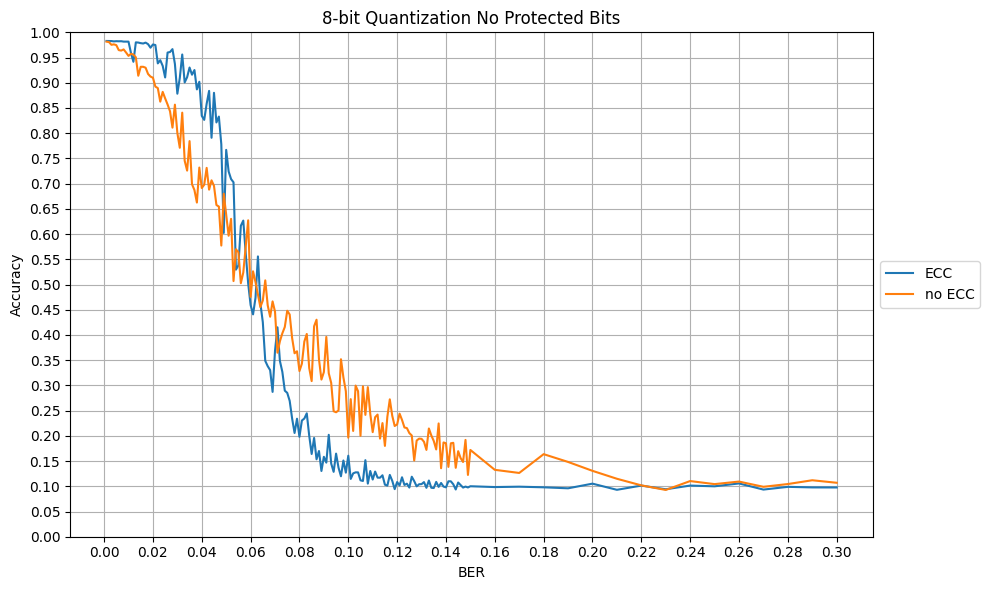

In [58]:
plt.figure(figsize=(10, 6))

plt.plot(x_8bitdense, avg_accuracies_8bitdense, label="ECC")
plt.plot(x_8bitdense, avg_accuracies_8bitdense_no_correct, label="no ECC")

plt.ylim(0, 1)
plt.yticks([x/20 for x in range(0, 21)])
plt.xticks([x for x in np.arange(0, 0.32, 0.02)])
#plt.xscale("log")  # optional if error_probs span magnitudes
plt.title("8-bit Quantization No Protected Bits")
plt.xlabel("BER")
plt.ylabel("Accuracy")
plt.grid(True)

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.savefig("accuracy_plots/notlog_same_errors_8bitdense.png", bbox_inches="tight")
plt.show()

### 4bit dense correct vs non-correct

In [9]:
set_seed(69)
train_data, train_label, test_data, test_label = load_data_set()

error_probs_same = np.arange(0.001, 0.301, 0.001).tolist()

bits_to_ignore = (4, 31)
name = "4bit_dense"
filename = "lenet5_dense_quantized_4.pt"
avg_accuracies_4bitdense = []
x_4bitdense = []

avg_accuracies_4bitdense_no_correct = []

for p_error in error_probs_same:
    print(f"current error: {p_error}")
    to_average = []
    to_average_no_correct = []
    
    for i in range(number_of_tests):
        accuracy = test8(
            pt_name=filename, p_error=p_error, p_protected=10**(-4),
            protected_range=(0,1), ignore_range=bits_to_ignore,
            test_data=test_data, test_label=test_label
        )
        
        to_average.append(accuracy)

        accuracy = test_no_error_correct(
            pt_name=filename, p_error=p_error, p_protected=10**(-4),
            protected_range=(0,1), ignore_range=bits_to_ignore,
            test_data=test_data, test_label=test_label
        )

        to_average_no_correct.append(accuracy)

    x_4bitdense.append(p_error)
    
    to_average = np.array(to_average)
    average = to_average.mean()
    print(f"resulting average: {average}")
    avg_accuracies_4bitdense.append(average)    

    to_average_no_correct = np.array(to_average_no_correct)
    average = to_average_no_correct.mean()
    print(f"resulting average: {average}")
    avg_accuracies_4bitdense_no_correct.append(average)

current error: 0.001


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(x_4bitdense, avg_accuracies_4bitdense, label=f"{name}")
plt.plot(x_4bitdense, avg_accuracies_4bitdense_no_correct, label=f"{name}_no_correct")

plt.ylim(0, 1)
plt.yticks([x/20 for x in range(0, 21)])
#plt.xscale("log")  # optional if error_probs span magnitudes
plt.title("same errors")
plt.xlabel("error")
plt.ylabel("Accuracy")
plt.grid(True)

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.savefig("accuracy_plots/notlog_same_errors_4bitdense.png", bbox_inches="tight")
plt.close()

In [ ]:
results_4_bit_dense = [x_4bitdense, avg_accuracies_4bitdense, avg_accuracies_4bitdense_no_correct]
with open("simulation_results/4bitdense_results", "wb") as f:
    pickle.dump(results_4_bit_dense, f)

In [ ]:
#test = []
#with open("simulation_results/4bitdense_results", "rb") as f:
#    test = pickle.load(f)

#print(len(test[0]), len(results_4_bit_dense[0]))
#print(test[0][:10], results_4_bit_dense[0][:10])
#print(test[1][:10], results_4_bit_dense[1][:10])

In [ ]:
with open("simulation_results/4bitdense_results", "rb") as f:
    x_4bitdense, avg_accuracies_4bitdense, avg_accuracies_4bitdense_no_correct = pickle.load(f)

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(x_4bitdense, avg_accuracies_4bitdense, label=f"ECC")
plt.plot(x_4bitdense, avg_accuracies_4bitdense_no_correct, label=f"no ECC")

plt.ylim(0, 1)
plt.yticks([x/20 for x in range(0, 21)])
#plt.xscale("log")  # optional if error_probs span magnitudes
plt.title("4-bit Quantization No Protected Bits")
plt.xlabel("BER")
plt.ylabel("Accuracy")
plt.grid(True)

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.savefig("accuracy_plots/notlog_same_errors_4bitdense.png", bbox_inches="tight")
plt.show()

## different errors

### 4bit dense correct vs non-correct

In [7]:
set_seed(69)
train_data, train_label, test_data, test_label = load_data_set()

error_probs_diff = np.arange(0.005, 1.005, 0.005).tolist()
filename = "lenet5_dense_quantized_4.pt"
bits_to_ignore = (4, 31)

x_4bitdense = error_probs_diff
avg_accuracies_4bitdense = []
avg_accuracies_4bitdense_no_correct = []

dict = torch.load(filename, map_location=torch.device('cpu'))

for i in range(0, 1):
    print(f"protected range: (0, {i})")
    protect_range = (0, i)

    avgs_4bitdense = []
    avgs_4bitdense_no_correct = []
    
    for p_error in error_probs_diff:
        print(f"current error: {p_error}")
        to_average = []
        to_average_no_correct = []
        
        for i in range(number_of_tests):
            accuracy = test8(
                pt_name=filename, p_error=p_error, p_protected=10**(-4),
                protected_range=protect_range, ignore_range=bits_to_ignore,
                test_data=test_data, test_label=test_label
            )
            
            to_average.append(accuracy)
    
            accuracy = test_no_error_correct(
                pt_name=filename, p_error=p_error, p_protected=10**(-4),
                protected_range=protect_range, ignore_range=bits_to_ignore,
                test_data=test_data, test_label=test_label
            )
    
            to_average_no_correct.append(accuracy)
        
        to_average = np.array(to_average)
        average = to_average.mean()
        print(f"resulting average: {average}")
        avgs_4bitdense.append(average)    
    
        to_average_no_correct = np.array(to_average_no_correct)
        average = to_average_no_correct.mean()
        print(f"resulting average: {average}")
        avgs_4bitdense_no_correct.append(average)

    
    avg_accuracies_4bitdense.append(avgs_4bitdense)
    avg_accuracies_4bitdense_no_correct.append(avgs_4bitdense_no_correct)

protected range: (0, 0)
current error: 0.005

Test set: Accuracy: 9813/10000 (98%), Error: 187/10000 (2%)


Test set: Accuracy: 9779/10000 (98%), Error: 221/10000 (2%)


Test set: Accuracy: 9782/10000 (98%), Error: 218/10000 (2%)


Test set: Accuracy: 9635/10000 (96%), Error: 365/10000 (4%)



KeyboardInterrupt: 

In [9]:
for i in range(1, 4):
    name = f"4bit_dense_(0,{i})_protected"
    
    plt.figure(figsize=(10, 6))
    
    plt.plot(x_4bitdense, avg_accuracies_4bitdense[i-1], label=f"{name}")
    plt.plot(x_4bitdense, avg_accuracies_4bitdense_no_correct[i-1], label=f"{name}_no_correct")
    
    plt.ylim(0, 1)
    plt.yticks([x/20 for x in range(0, 21)])
    #plt.xscale("log")  # optional if error_probs span magnitudes
    plt.title("same errors")
    plt.xlabel("error")
    plt.ylabel("Accuracy")
    plt.grid(True)
    
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    
    plt.savefig(f"accuracy_plots/notlog_diff_errors_{name}.png", bbox_inches="tight")
    plt.close()

In [10]:
results_4_bit_dense = [x_4bitdense, avg_accuracies_4bitdense, avg_accuracies_4bitdense_no_correct]
with open("simulation_results/4bitdense_diff_errors_results", "wb") as f:
    pickle.dump(results_4_bit_dense, f)

In [9]:
with open("simulation_results/4bitdense_diff_errors_results", "rb") as f:
    x_4bitdense, avg_accuracies_4bitdense, avg_accuracies_4bitdense_no_correct = pickle.load(f)

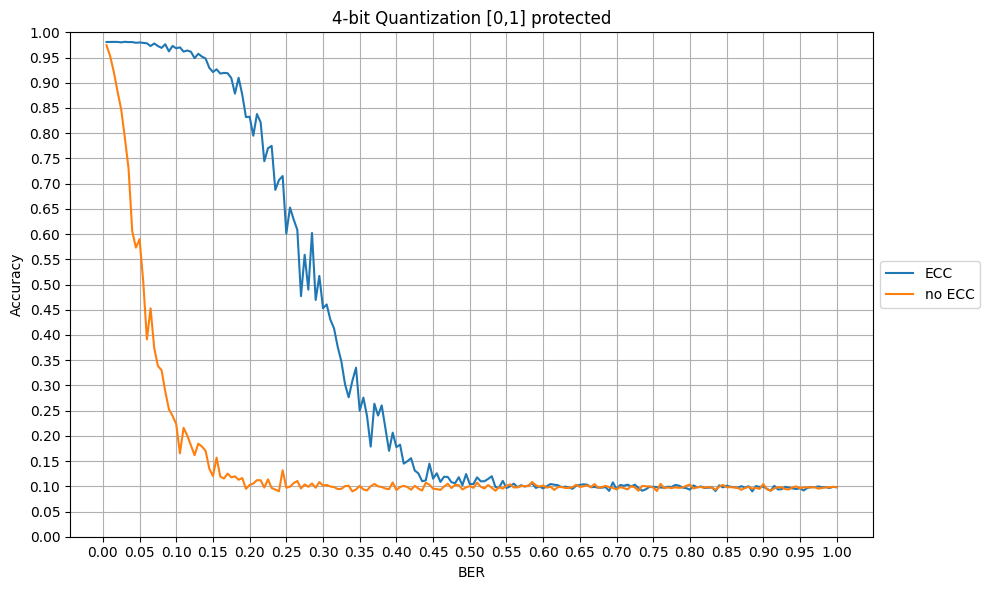

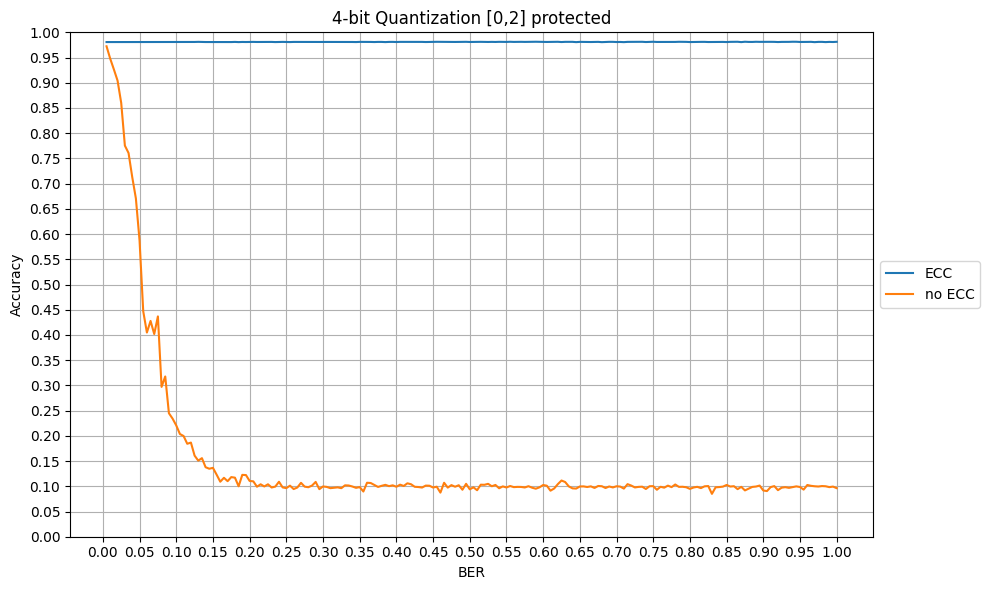

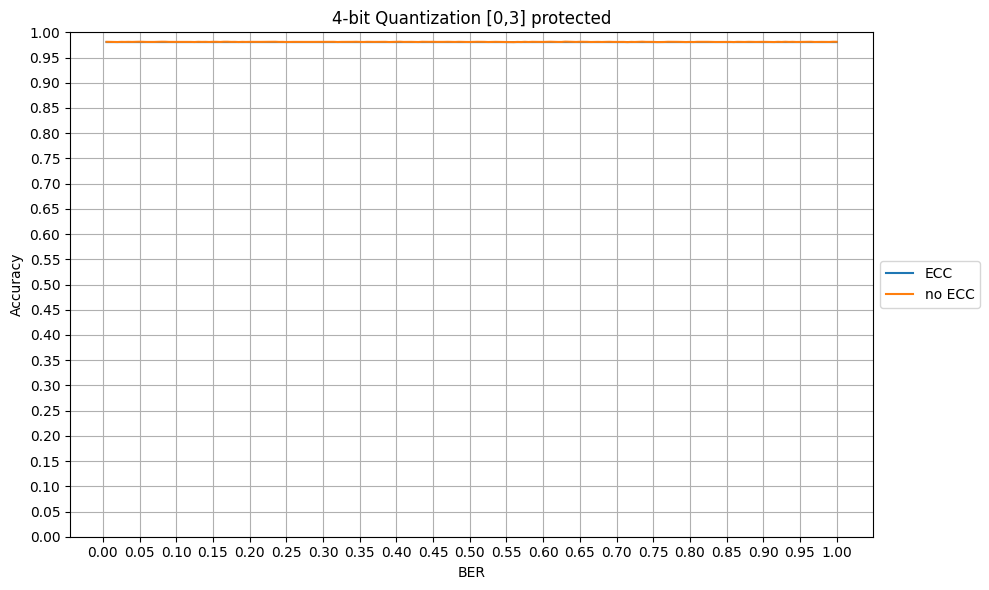

In [10]:
for i in range(1, 4):
    name = f"4bit_(0,{i})_protected"
    
    plt.figure(figsize=(10, 6))
    
    plt.plot(x_4bitdense, avg_accuracies_4bitdense[i-1], label=f"ECC")
    plt.plot(x_4bitdense, avg_accuracies_4bitdense_no_correct[i-1], label=f"no ECC")
    
    plt.ylim(0, 1)
    plt.yticks([x/20 for x in range(0, 21)])
    plt.xticks([x for x in np.arange(0, 1.05, 0.05)])
    #plt.xscale("log")  # optional if error_probs span magnitudes
    plt.title(f"4-bit Quantization [0,{i}] protected")
    plt.xlabel("BER")
    plt.ylabel("Accuracy")
    plt.grid(True)
    
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    
    plt.savefig(f"accuracy_plots/notlog_diff_errors_{name}.png", bbox_inches="tight")
    plt.show()

### 8bit dense correct vs non-correct

In [77]:
set_seed(69)
train_data, train_label, test_data, test_label = load_data_set()

error_probs_diff = np.arange(0.005, 1.005, 0.005).tolist()
filename = "lenet5_dense_quantized.pt"
bits_to_ignore = (8, 31)

x_8bitdense = error_probs_diff
avg_accuracies_8bitdense = []
avg_accuracies_8bitdense_no_correct = []

for i in range(1, 8):
    print(f"protected range: (0, {i})")
    protect_range = (0, i)

    avgs_8bitdense = []
    avgs_8bitdense_no_correct = []
    
    for p_error in error_probs_diff:
        print(f"current error: {p_error}")
        to_average = []
        to_average_no_correct = []
        
        for i in range(number_of_tests):
            accuracy = test8(
                pt_name=filename, p_error=p_error, p_protected=p_error,
                protected_range=protect_range, ignore_range=bits_to_ignore,
                test_data=test_data, test_label=test_label
            )
            
            to_average.append(accuracy)
    
            accuracy = test_no_error_correct(
                pt_name=filename, p_error=p_error, p_protected=p_error,
                protected_range=protect_range, ignore_range=bits_to_ignore,
                test_data=test_data, test_label=test_label
            )
    
            to_average_no_correct.append(accuracy)
        
        to_average = np.array(to_average)
        average = to_average.mean()
        print(f"resulting average: {average}")
        avgs_8bitdense.append(average)    
    
        to_average_no_correct = np.array(to_average_no_correct)
        average = to_average_no_correct.mean()
        print(f"resulting average: {average}")
        avgs_8bitdense_no_correct.append(average)

    
    avg_accuracies_8bitdense.append(avgs_8bitdense)
    avg_accuracies_8bitdense_no_correct.append(avgs_8bitdense_no_correct)

protected range: (0, 1)
current error: 0.005

Test set: Accuracy: 9818/10000 (98%), Error: 182/10000 (2%)


Test set: Accuracy: 9672/10000 (97%), Error: 328/10000 (3%)


Test set: Accuracy: 9823/10000 (98%), Error: 177/10000 (2%)


Test set: Accuracy: 9776/10000 (98%), Error: 224/10000 (2%)


Test set: Accuracy: 9823/10000 (98%), Error: 177/10000 (2%)


Test set: Accuracy: 9772/10000 (98%), Error: 228/10000 (2%)


Test set: Accuracy: 9818/10000 (98%), Error: 182/10000 (2%)


Test set: Accuracy: 9678/10000 (97%), Error: 322/10000 (3%)


Test set: Accuracy: 9826/10000 (98%), Error: 174/10000 (2%)


Test set: Accuracy: 9779/10000 (98%), Error: 221/10000 (2%)


Test set: Accuracy: 9828/10000 (98%), Error: 172/10000 (2%)


Test set: Accuracy: 9772/10000 (98%), Error: 228/10000 (2%)


Test set: Accuracy: 9829/10000 (98%), Error: 171/10000 (2%)


Test set: Accuracy: 9729/10000 (97%), Error: 271/10000 (3%)


Test set: Accuracy: 9827/10000 (98%), Error: 173/10000 (2%)


Test set: Accuracy: 9794

KeyboardInterrupt: 

In [ ]:
for i in range(1, 8):
    name = f"8bit_dense_(0,{i})_protected"
    
    plt.figure(figsize=(10, 6))
    
    plt.plot(x_8bitdense, avg_accuracies_8bitdense[i], label=f"{name}")
    plt.plot(x_8bitdense, avg_accuracies_8bitdense_no_correct[i], label=f"{name}_no_correct")
    
    plt.ylim(0, 1)
    plt.yticks([x/20 for x in range(0, 21)])
    #plt.xscale("log")  # optional if error_probs span magnitudes
    plt.title("same errors")
    plt.xlabel("error")
    plt.ylabel("Accuracy")
    plt.grid(True)
    
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    
    plt.savefig(f"accuracy_plots/notlog_diff_errors_{name}.png", bbox_inches="tight")
    plt.close()

In [ ]:
#results_8_bit_dense = [x_8bitdense, avg_accuracies_8bitdense, avg_accuracies_8bitdense_no_correct]
#with open("simulation_results/8bitdense_diff_errors_results", "wb") as f:
#    pickle.dump(results_8_bit_dense, f)

In [30]:
with open("simulation_results/8bitdense_diff_errors_results", "rb") as f:
    x_8bitdense, avg_accuracies_8bitdense, avg_accuracies_8bitdense_no_correct = pickle.load(f)

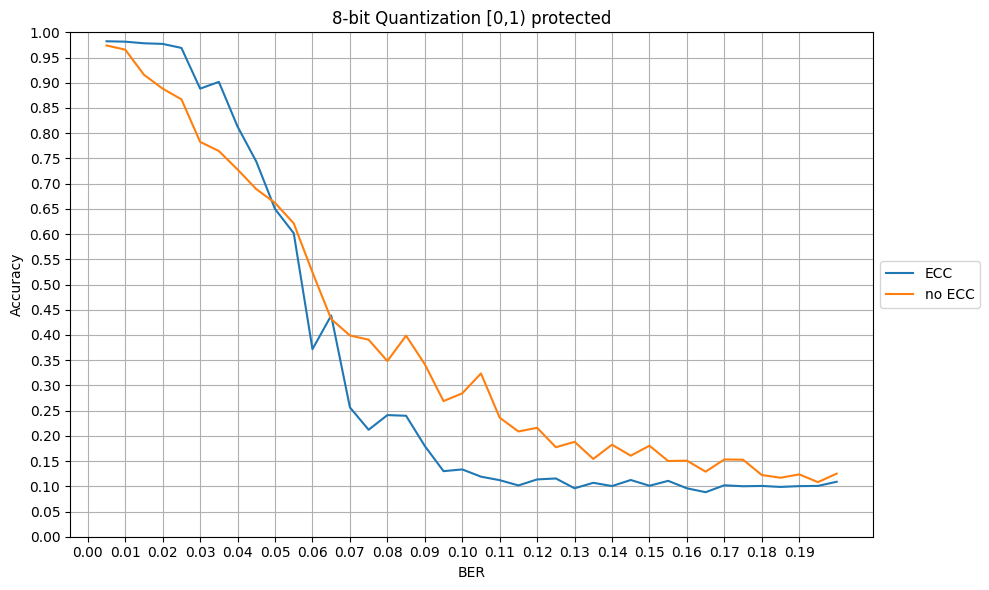

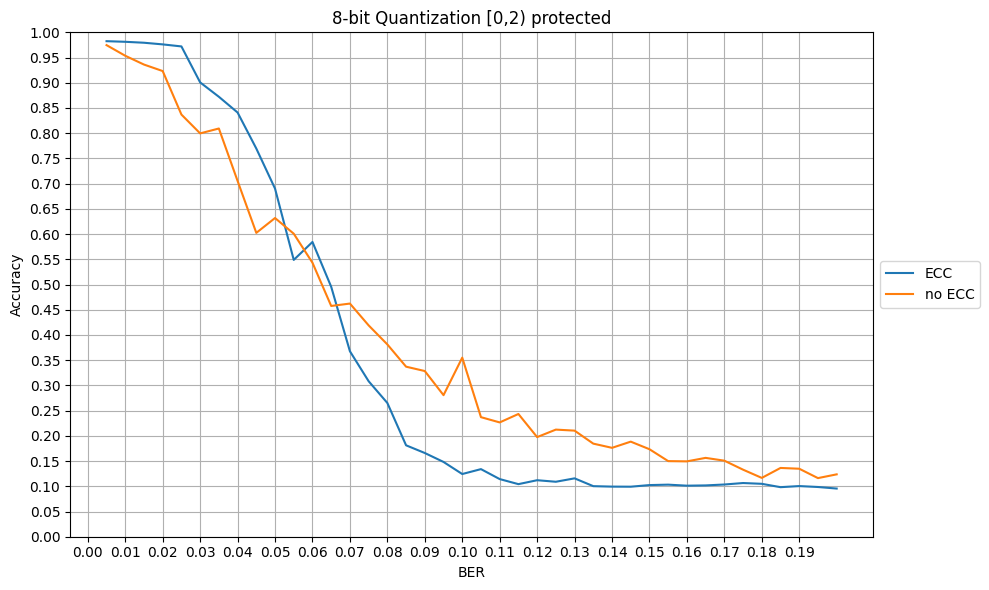

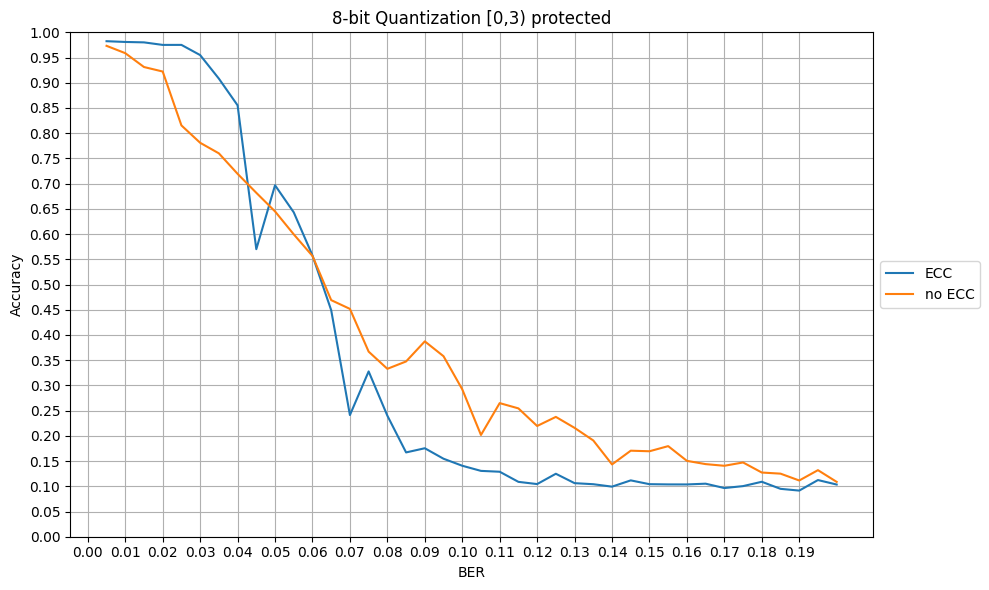

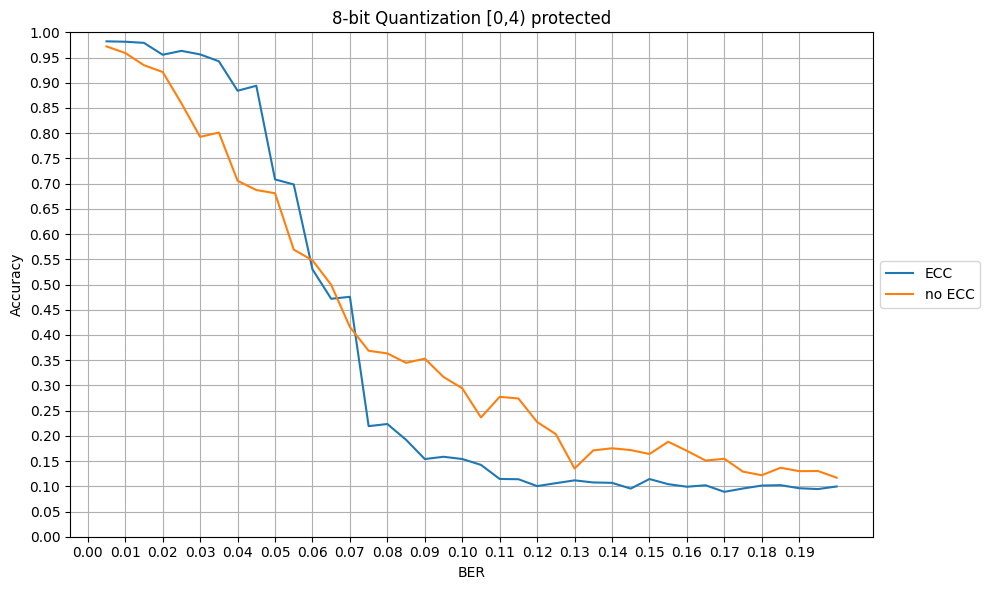

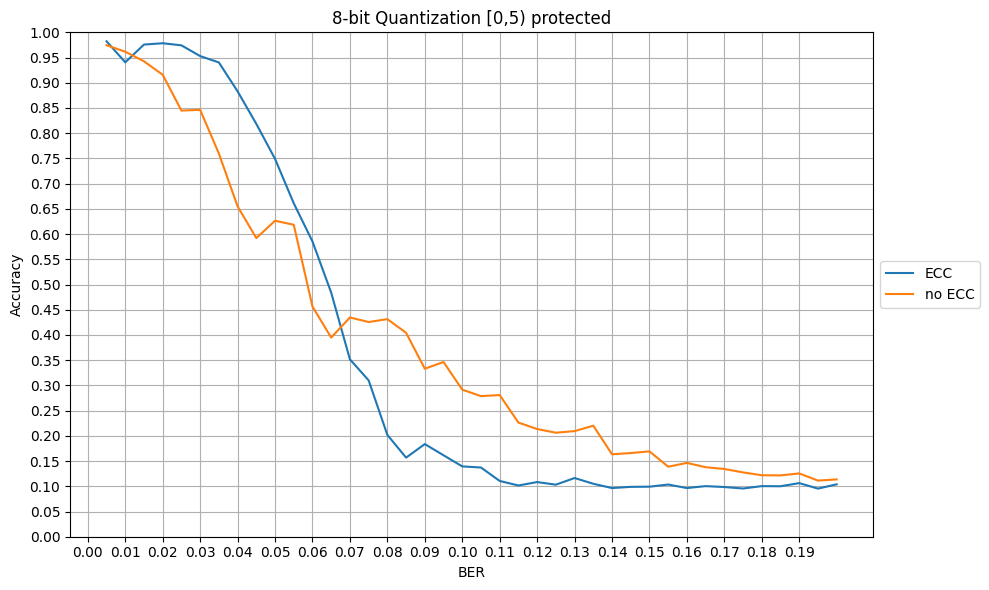

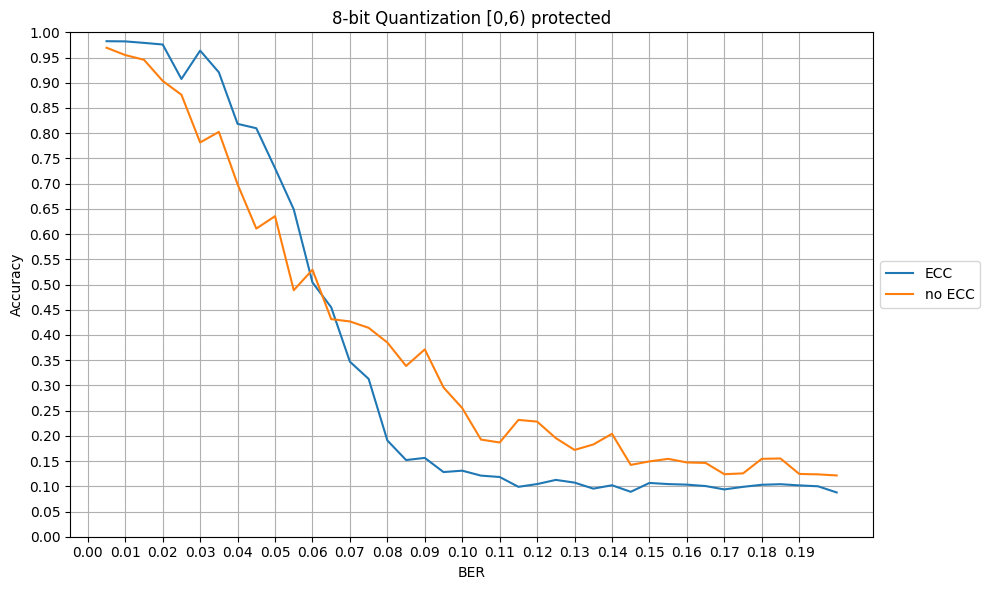

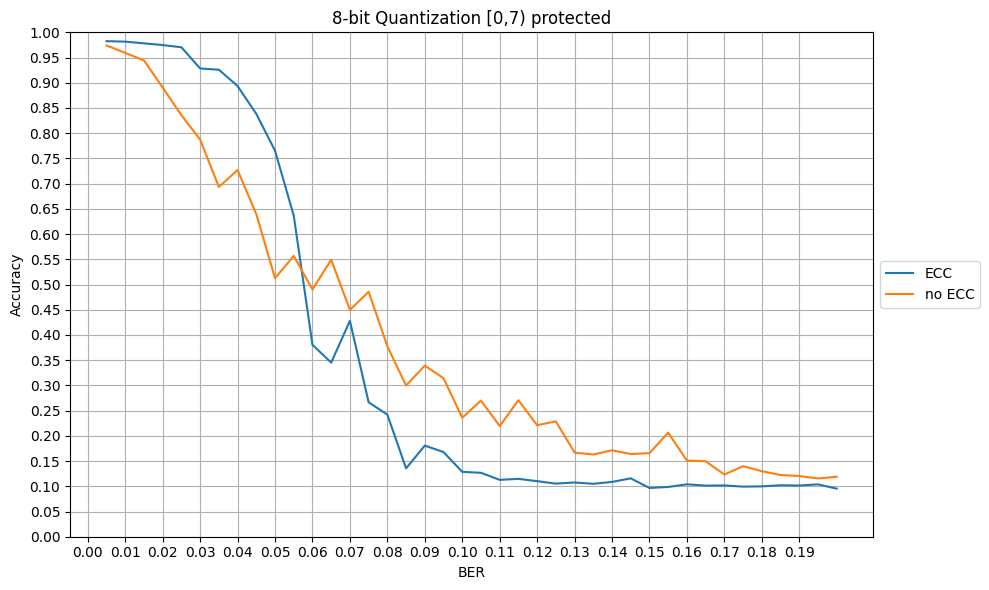

In [49]:
for i in range(1, 8):
    name = f"8-bit_(0,{i})_protected"
    
    plt.figure(figsize=(10, 6))
    
    plt.plot(x_8bitdense[:40], avg_accuracies_8bitdense[i-1][:40], label=f"ECC")
    plt.plot(x_8bitdense[:40], avg_accuracies_8bitdense_no_correct[i-1][:40], label=f"no ECC")
    
    plt.ylim(0, 1)
    plt.yticks([x/20 for x in range(0, 21)])
    plt.xticks([x for x in np.arange(0, 0.20, 0.01)])
    #plt.xscale("log")  # optional if error_probs span magnitudes
    plt.title(f"8-bit Quantization [0,{i}) protected")
    plt.xlabel("BER")
    plt.ylabel("Accuracy")
    plt.grid(True)
    
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    
    plt.savefig(f"accuracy_plots/diff_errors_{name}.png", bbox_inches="tight")
    plt.show()

### 8bit sparse correct vs non-correct

In [ ]:
set_seed(69)
train_data, train_label, test_data, test_label = load_data_set()

error_probs_diff = np.arange(0.005, 1.005, 0.005).tolist()
filename = "lenet5_sparse_quantized.pt"
bits_to_ignore = (8, 31)

x_8bitsparse = error_probs_diff
avg_accuracies_8bitsparse = []
avg_accuracies_8bitsparse_no_correct = []

for i in range(1, 8):
    print(f"protected range: (0, {i})")
    protect_range = (0, i)

    avgs_8bitsparse = []
    avgs_8bitsparse_no_correct = []
    
    for p_error in error_probs_diff:
        print(f"current error: {p_error}")
        to_average = []
        to_average_no_correct = []
        
        for i in range(number_of_tests):
            accuracy = test8(
                pt_name=filename, p_error=p_error, p_protected=p_error,
                protected_range=protect_range, ignore_range=bits_to_ignore,
                test_data=test_data, test_label=test_label
            )
            
            to_average.append(accuracy)
    
            accuracy = test_no_error_correct(
                pt_name=filename, p_error=p_error, p_protected=p_error,
                protected_range=protect_range, ignore_range=bits_to_ignore,
                test_data=test_data, test_label=test_label
            )
    
            to_average_no_correct.append(accuracy)
        
        to_average = np.array(to_average)
        average = to_average.mean()
        print(f"resulting average: {average}")
        avgs_8bitsparse.append(average)    
    
        to_average_no_correct = np.array(to_average_no_correct)
        average = to_average_no_correct.mean()
        print(f"resulting average: {average}")
        avgs_8bitsparse_no_correct.append(average)

    
    avg_accuracies_8bitsparse.append(avgs_8bitsparse)
    avg_accuracies_8bitsparse_no_correct.append(avgs_8bitsparse_no_correct)

In [ ]:
for i in range(1, 8):
    name = f"8bit_sparse_(0,{i})_protected"
    
    plt.figure(figsize=(10, 6))
    
    plt.plot(x_8bitsparse, avg_accuracies_8bitsparse[i-1], label=f"{name}")
    plt.plot(x_8bitsparse, avg_accuracies_8bitsparse_no_correct[i-1], label=f"{name}_no_correct")
    
    plt.ylim(0, 1)
    plt.yticks([x/20 for x in range(0, 21)])
    #plt.xscale("log")  # optional if error_probs span magnitudes
    plt.title("same errors")
    plt.xlabel("error")
    plt.ylabel("Accuracy")
    plt.grid(True)
    
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    
    plt.savefig(f"accuracy_plots/notlog_diff_errors_{name}.png", bbox_inches="tight")
    plt.close()

In [ ]:
#results_8_bit_sparse = [x_8bitsparse, avg_accuracies_8bitsparse, avg_accuracies_8bitsparse_no_correct]
#with open("simulation_results/8bitsparse_diff_errors_results", "wb") as f:
#    pickle.dump(results_8_bit_sparse, f)

### 16bit dense correct vs non-correct

In [12]:
set_seed(69)
train_data, train_label, test_data, test_label = load_data_set()

error_probs_diff = (
                    np.arange(0.001, 0.003, 0.001).tolist()
                  + np.arange(0.0025, 0.0155, 0.0001).tolist()
                  + np.arange(0.005, 1.005, 0.005).tolist()
                   )

filename = "lenet5_dense_quantized_16.pt"
bits_to_ignore = (16, 31)

x_16bitdense = error_probs_diff
avg_accuracies_16bitdense = []
avg_accuracies_16bitdense_no_correct = []

for i in range(1, 16):
    print(f"protected range: (0, {i})")
    protect_range = (0, i)

    avgs_16bitdense = []
    avgs_16bitdense_no_correct = []
    
    for p_error in error_probs_diff:
        print(f"current error: {p_error}")
        to_average = []
        to_average_no_correct = []
        
        for i in range(number_of_tests):
            accuracy = test8(
                pt_name=filename, p_error=p_error, p_protected=10**(-4),
                protected_range=protect_range, ignore_range=bits_to_ignore,
                test_data=test_data, test_label=test_label
            )
            
            to_average.append(accuracy)
    
            accuracy = test_no_error_correct(
                pt_name=filename, p_error=p_error, p_protected=10**(-4),
                protected_range=protect_range, ignore_range=bits_to_ignore,
                test_data=test_data, test_label=test_label
            )
    
            to_average_no_correct.append(accuracy)
        
        to_average = np.array(to_average)
        average = to_average.mean()
        print(f"resulting average: {average}")
        avgs_16bitdense.append(average)    
    
        to_average_no_correct = np.array(to_average_no_correct)
        average = to_average_no_correct.mean()
        print(f"resulting average: {average}")
        avgs_16bitdense_no_correct.append(average)

    
    avg_accuracies_16bitdense.append(avgs_16bitdense)
    avg_accuracies_16bitdense_no_correct.append(avgs_16bitdense_no_correct)

protected range: (0, 1)
current error: 0.001

Test set: Accuracy: 9829/10000 (98%), Error: 171/10000 (2%)


Test set: Accuracy: 9830/10000 (98%), Error: 170/10000 (2%)


Test set: Accuracy: 9831/10000 (98%), Error: 169/10000 (2%)


Test set: Accuracy: 9810/10000 (98%), Error: 190/10000 (2%)


Test set: Accuracy: 9822/10000 (98%), Error: 178/10000 (2%)


Test set: Accuracy: 9814/10000 (98%), Error: 186/10000 (2%)


Test set: Accuracy: 9828/10000 (98%), Error: 172/10000 (2%)


Test set: Accuracy: 9793/10000 (98%), Error: 207/10000 (2%)


Test set: Accuracy: 9830/10000 (98%), Error: 170/10000 (2%)


Test set: Accuracy: 9815/10000 (98%), Error: 185/10000 (2%)


Test set: Accuracy: 9828/10000 (98%), Error: 172/10000 (2%)


Test set: Accuracy: 9821/10000 (98%), Error: 179/10000 (2%)


Test set: Accuracy: 9827/10000 (98%), Error: 173/10000 (2%)


Test set: Accuracy: 9821/10000 (98%), Error: 179/10000 (2%)


Test set: Accuracy: 9829/10000 (98%), Error: 171/10000 (2%)


Test set: Accuracy: 9817


KeyboardInterrupt

Exception ignored in: 'zmq.backend.cython._zmq.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/_zmq.py", line 179, in zmq.backend.cython._zmq._check_rc
    PyErr_CheckSignals()
KeyboardInterrupt: 

KeyboardInterrupt



In [ ]:
for i in range(1, 16):
    name = f"16bit_dense_(0,{i})_protected"
    
    plt.figure(figsize=(10, 6))
    
    plt.plot(x_16bitdense, avg_accuracies_16bitdense[i-1], label=f"{name}")
    plt.plot(x_16bitdense, avg_accuracies_16bitdense_no_correct[i-1], label=f"{name}_no_correct")
    
    plt.ylim(0, 1)
    plt.yticks([x/20 for x in range(0, 21)])
    #plt.xscale("log")  # optional if error_probs span magnitudes
    plt.title("same errors")
    plt.xlabel("error")
    plt.ylabel("Accuracy")
    plt.grid(True)
    
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    
    plt.savefig(f"accuracy_plots/notlog_diff_errors_{name}.png", bbox_inches="tight")
    plt.close()

In [ ]:
results_16_bit_dense = [x_16bitdense, avg_accuracies_16bitdense, avg_accuracies_16bitdense_no_correct]
with open("simulation_results/16bitdense_diff_errors_results", "wb") as f:
    pickle.dump(results_16_bit_dense, f)

In [ ]:
with open("simulation_results/16bitdense_diff_errors_results", "rb") as f:
    x_16bitdense, avg_accuracies_16bitdense, avg_accuracies_16bitdense_no_correct = pickle.load(f)

In [ ]:
for i in range(1, 16):
    name = f"16bit_[0,{i})_protected"
    
    plt.figure(figsize=(10, 6))
    
    #plt.plot(x_16bitdense[:80], avg_accuracies_16bitdense[i-1][:80], label=f"ECC")
    #plt.plot(x_16bitdense[:80], avg_accuracies_16bitdense_no_correct[i-1][:80], label=f"no ECC")

    plt.plot(x_16bitdense, avg_accuracies_16bitdense[i-1], label=f"ECC")
    plt.plot(x_16bitdense, avg_accuracies_16bitdense_no_correct[i-1], label=f"no ECC")
    
    plt.ylim(0, 1)
    plt.yticks([x/20 for x in range(0, 21)])
    #plt.xticks([x for x in np.arange(0, 0.01, 0.001)])
    #plt.xscale("log")  # optional if error_probs span magnitudes
    plt.title(f"16-bit Quantization [0,{i}) protected")
    plt.xlabel("BER")
    plt.ylabel("Accuracy")
    plt.grid(True)
    
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    
    plt.savefig(f"accuracy_plots/notlog_diff_errors_{name}.png", bbox_inches="tight")
    plt.show()

## previous stuff

### tests

In [5]:
set_seed(69)
train_data, train_label, test_data, test_label = load_data_set()


error_probs_diff = np.arange(0.001, 0.301, 0.001).tolist()

error_probs_same = np.arange(0.001, 0.301, 0.001).tolist()


############################################
############# different errors #############
############################################
filenames = {
    "8bit_sparse": "lenet5_sparse_quantized.pt",
    "8bit_dense": "lenet5_dense_quantized.pt",
    "16bit_dense": "lenet5_dense_quantized_16.pt",
    "4bit_dense": "lenet5_dense_quantized_4.pt",
}

bits_to_ignore = {
    "8bit_sparse": (8, 31),
    "8bit_dense": (8, 31),
    "16bit_dense": (16, 31),
    "4bit_dense": (4, 31),
}

protected_bits = {
    "8bit_sparse": range(1, 8),
    "8bit_dense": range(1, 8),
    "16bit_dense": range(1, 16),
    "4bit_dense": range(1, 4),
}

error_probs = error_probs_diff  # your list of p_error values

# results[p_bits][model] = list of accuracies over p_error
results = {model: {p: [] for p in protected_bits[model]} for model in protected_bits}

for p_error in error_probs:
    print(f"p_error: {p_error}")
    for model, bit_range in protected_bits.items():
        for pbits in bit_range:
            accuracy = test8(
                pt_name=filenames[model],
                p_error=p_error,
                p_protected=1e-8,
                protected_range=(0, pbits),
                ignore_range=bits_to_ignore[model],
                test_data=test_data,
                test_label=test_label,
            )
            results[model][pbits].append(accuracy)



############################################
############### same error #################
############################################

results_same = {"8bit_sparse": [], "8bit_dense": [], "16bit_dense": [], "4bit_dense": []}
x_labels_same = {"8bit_sparse": [], "8bit_dense": [], "16bit_dense": [], "4bit_dense": []}

for p_error in error_probs_same:
    print(f"error prob: {p_error}")

    configs = [
        ("8bit_sparse", "lenet5_sparse_quantized.pt", (0,1), (8,31)),
        ("8bit_dense", "lenet5_dense_quantized.pt", (0,1), (8,31)),
        ("16bit_dense", "lenet5_dense_quantized_16.pt", (0,1), (16,31)),
        ("4bit_dense", "lenet5_dense_quantized_4.pt", (0,1), (4,31))
    ]

    for name, pt, prange, irange in configs:
        accuracy = test8(
            pt_name=pt, p_error=p_error, p_protected=p_error,
            protected_range=prange, ignore_range=irange,
            test_data=test_data, test_label=test_label
        )

        results_same[name].append(accuracy)
        x_labels_same[name].append(p_error)

p_error: 0.001

Test set: Accuracy: 9821/10000 (98%), Error: 179/10000 (2%)


Test set: Accuracy: 9821/10000 (98%), Error: 179/10000 (2%)


Test set: Accuracy: 9821/10000 (98%), Error: 179/10000 (2%)


Test set: Accuracy: 9821/10000 (98%), Error: 179/10000 (2%)


Test set: Accuracy: 9821/10000 (98%), Error: 179/10000 (2%)


Test set: Accuracy: 9821/10000 (98%), Error: 179/10000 (2%)


Test set: Accuracy: 9821/10000 (98%), Error: 179/10000 (2%)


Test set: Accuracy: 9827/10000 (98%), Error: 173/10000 (2%)


Test set: Accuracy: 9829/10000 (98%), Error: 171/10000 (2%)


Test set: Accuracy: 9829/10000 (98%), Error: 171/10000 (2%)


Test set: Accuracy: 9829/10000 (98%), Error: 171/10000 (2%)


Test set: Accuracy: 9829/10000 (98%), Error: 171/10000 (2%)


Test set: Accuracy: 9829/10000 (98%), Error: 171/10000 (2%)


Test set: Accuracy: 9829/10000 (98%), Error: 171/10000 (2%)


Test set: Accuracy: 9828/10000 (98%), Error: 172/10000 (2%)


Test set: Accuracy: 9829/10000 (98%), Error: 171/10000

In [6]:
plt.figure(figsize=(10, 6))

for model in results:
    for pbits, acc_list in results[model].items():
        plt.scatter(error_probs, acc_list, label=f"{model} | {pbits} bits")

    plt.ylim(0, 1)
    plt.yticks([x/20 for x in range(0, 21)])
    #plt.xscale("log")  # optional if error_probs span magnitudes
    plt.xlabel("p_error")
    plt.ylabel("Accuracy")
    plt.title("diff error")
    plt.grid(True)
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.savefig(f"accuracy_plots/{model}_notlog_diff_errors.png", bbox_inches="tight")
    plt.close()

In [7]:
plt.figure(figsize=(10, 6))
counter = 1
model = "16bit_dense"
for pbits, acc_list in results[model].items():
    plt.scatter(error_probs, acc_list, label=f"{model} | {pbits} bits")

    counter += 1
    if (counter % 16) == 0:
        plt.ylim(0, 1)
        plt.yticks([x/20 for x in range(0, 21)])
        #plt.xscale("log")  # optional if error_probs span magnitudes
        plt.xlabel("p_error")
        plt.ylabel("Accuracy")
        plt.title("diff error")
        plt.grid(True)
        plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
        plt.tight_layout()
        plt.savefig(f"accuracy_plots/{model}_{counter}_notlog_diff_errors.png", bbox_inches="tight")
        plt.close()
    elif (counter % 8) == 0:
        plt.ylim(0, 1)
        plt.yticks([x/20 for x in range(0, 21)])
        #plt.xscale("log")  # optional if error_probs span magnitudes
        plt.xlabel("p_error")
        plt.ylabel("Accuracy")
        plt.title("diff error")
        plt.grid(True)
        plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
        plt.tight_layout()
        plt.savefig(f"accuracy_plots/{model}_{counter}_notlog_diff_errors.png", bbox_inches="tight")
        plt.close()
        plt.figure(figsize=(10, 6))


    

In [8]:
plt.figure(figsize=(10, 6))
for key in ["16bit_dense", "8bit_dense", "8bit_sparse", "4bit_dense"]:
    plt.scatter(x_labels_same[key], results_same[key], label=f"{key}")

plt.ylim(0, 1)
plt.yticks([x/20 for x in range(0, 21)])
#plt.xscale("log")  # optional if error_probs span magnitudes
plt.title("same errors")
plt.xlabel("error")
plt.ylabel("Accuracy")
plt.grid(True)

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.savefig("accuracy_plots/notlog_same_errors.png", bbox_inches="tight")
plt.close()

### no error correct:

In [30]:
set_seed(69)
train_data, train_label, test_data, test_label = load_data_set()


error_probs_diff = np.arange(0.75, 1.05, 0.05).tolist()

error_probs_same = np.arange(0.75, 1.05, 0.05).tolist()


############################################
############# different errors #############
############################################
filenames = {
    "8bit_sparse": "lenet5_sparse_quantized.pt",
    "8bit_dense": "lenet5_dense_quantized.pt",
    "16bit_dense": "lenet5_dense_quantized_16.pt",
    "4bit_dense": "lenet5_dense_quantized_4.pt",
}

bits_to_ignore = {
    "8bit_sparse": (8, 31),
    "8bit_dense": (8, 31),
    "16bit_dense": (16, 31),
    "4bit_dense": (4, 31),
}

protected_bits = {
    "8bit_sparse": range(1, 8),
    "8bit_dense": range(1, 8),
    "16bit_dense": range(1, 16),
    "4bit_dense": range(1, 4),
}

error_probs = error_probs_diff  # your list of p_error values

# results[p_bits][model] = list of accuracies over p_error
results_no_correct = {model: {p: [] for p in protected_bits[model]} for model in protected_bits}

for p_error in error_probs:
    print(f"p_error: {p_error}")
    for model, bit_range in protected_bits.items():
        for pbits in bit_range:
            accuracy = test_no_error_correct(
                pt_name=filenames[model],
                p_error=p_error,
                p_protected=1e-8,
                protected_range=(0, pbits),
                ignore_range=bits_to_ignore[model],
                test_data=test_data,
                test_label=test_label,
            )
            results_no_correct[model][pbits].append(accuracy)



############################################
############### same error #################
############################################

results_same_no_correct = {"8bit_sparse": [], "8bit_dense": [], "16bit_dense": [], "4bit_dense": []}
x_labels_same_no_correct = {"8bit_sparse": [], "8bit_dense": [], "16bit_dense": [], "4bit_dense": []}

for p_error in error_probs_same:
    print(f"error prob: {p_error}")

    configs = [
        ("8bit_sparse", "lenet5_sparse_quantized.pt", (0,1), (8,31)),
        ("8bit_dense", "lenet5_dense_quantized.pt", (0,1), (8,31)),
        ("16bit_dense", "lenet5_dense_quantized_16.pt", (0,1), (16,31)),
        ("4bit_dense", "lenet5_dense_quantized_4.pt", (0,1), (4,31))
    ]

    for name, pt, prange, irange in configs:
        accuracy = test_no_error_correct(
            pt_name=pt, p_error=p_error, p_protected=p_error,
            protected_range=prange, ignore_range=irange,
            test_data=test_data, test_label=test_label
        )

        results_same_no_correct[name].append(accuracy)
        x_labels_same_no_correct[name].append(p_error)

p_error: 0.75

Test set: Accuracy: 974/10000 (10%), Error: 9026/10000 (90%)


Test set: Accuracy: 1004/10000 (10%), Error: 8996/10000 (90%)


Test set: Accuracy: 1135/10000 (11%), Error: 8865/10000 (89%)


Test set: Accuracy: 1032/10000 (10%), Error: 8968/10000 (90%)


Test set: Accuracy: 982/10000 (10%), Error: 9018/10000 (90%)


Test set: Accuracy: 1032/10000 (10%), Error: 8968/10000 (90%)


Test set: Accuracy: 9821/10000 (98%), Error: 179/10000 (2%)


Test set: Accuracy: 909/10000 (9%), Error: 9091/10000 (91%)


Test set: Accuracy: 809/10000 (8%), Error: 9191/10000 (92%)


Test set: Accuracy: 1066/10000 (11%), Error: 8934/10000 (89%)


Test set: Accuracy: 1020/10000 (10%), Error: 8980/10000 (90%)


Test set: Accuracy: 953/10000 (10%), Error: 9047/10000 (90%)


Test set: Accuracy: 1010/10000 (10%), Error: 8990/10000 (90%)


Test set: Accuracy: 9829/10000 (98%), Error: 171/10000 (2%)


Test set: Accuracy: 980/10000 (10%), Error: 9020/10000 (90%)


Test set: Accuracy: 1003/10000 (10%),

In [31]:
plt.figure(figsize=(10, 6))

for model in results_no_correct:
    for pbits, acc_list in results_no_correct[model].items():
        plt.scatter(error_probs, acc_list, label=f"{model} | {pbits} bits")

    plt.ylim(0, 1)
    plt.yticks([x/20 for x in range(0, 21)])
    #plt.xscale("log")  # optional if error_probs span magnitudes
    plt.xlabel("p_error")
    plt.ylabel("Accuracy")
    plt.title("diff error")
    plt.grid(True)
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.savefig(f"accuracy_plots/{model}_notlog_diff_errors_no_correct.png", bbox_inches="tight")
    plt.close()

In [32]:
plt.figure(figsize=(10, 6))
counter = 1
model = "16bit_dense"
for pbits, acc_list in results_no_correct[model].items():
    plt.scatter(error_probs, acc_list, label=f"{model} | {pbits} bits")

    counter += 1
    if (counter % 16) == 0:
        plt.ylim(0, 1)
        plt.yticks([x/20 for x in range(0, 21)])
        #plt.xscale("log")  # optional if error_probs span magnitudes
        plt.xlabel("p_error")
        plt.ylabel("Accuracy")
        plt.title("diff error")
        plt.grid(True)
        plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
        plt.tight_layout()
        plt.savefig(f"accuracy_plots/{model}_{counter}_notlog_diff_errors_no_correct.png", bbox_inches="tight")
        plt.close()
    elif (counter % 8) == 0:
        plt.ylim(0, 1)
        plt.yticks([x/20 for x in range(0, 21)])
        #plt.xscale("log")  # optional if error_probs span magnitudes
        plt.xlabel("p_error")
        plt.ylabel("Accuracy")
        plt.title("diff error")
        plt.grid(True)
        plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
        plt.tight_layout()
        plt.savefig(f"accuracy_plots/{model}_{counter}_notlog_diff_errors_no_correct.png", bbox_inches="tight")
        plt.close()
        plt.figure(figsize=(10, 6))


    

In [33]:
plt.figure(figsize=(10, 6))
for key in ["16bit_dense", "8bit_dense", "8bit_sparse", "4bit_dense"]:
    plt.scatter(x_labels_same_no_correct[key], results_same_no_correct[key], label=f"{key}")

plt.ylim(0, 1)
plt.yticks([x/20 for x in range(0, 21)])
#plt.xscale("log")  # optional if error_probs span magnitudes
plt.title("same errors")
plt.xlabel("error")
plt.ylabel("Accuracy")
plt.grid(True)

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.savefig("accuracy_plots/notlog_same_errors_no_correct.png", bbox_inches="tight")
plt.close()

### extra test 16 bit dense p < 0.01

In [10]:
set_seed(69)
train_data, train_label, test_data, test_label = load_data_set()

error_probs_diff = np.arange(0.0011, 0.021, 0.0001).tolist()
error_probs_same = np.arange(0.0011, 0.021, 0.0001).tolist()

############################################
############# different errors #############
############################################
filenames = {
    "16bit_dense": "lenet5_dense_quantized_16.pt",
}

bits_to_ignore = {
    "16bit_dense": (16, 31),
}

protected_bits = {
    "16bit_dense": range(1, 3),
}

error_probs = error_probs_diff  # your list of p_error values

# results[p_bits][model] = list of accuracies over p_error
results_extra = {model: {p: [] for p in protected_bits[model]} for model in protected_bits}

for p_error in error_probs:
    print(f"p_error: {p_error}")
    for model, bit_range in protected_bits.items():
        for pbits in bit_range:
            accuracy = test8(
                pt_name=filenames[model],
                p_error=p_error,
                p_protected=1e-8,
                protected_range=(0, pbits),
                ignore_range=bits_to_ignore[model],
                test_data=test_data,
                test_label=test_label,
            )
            results_extra[model][pbits].append(accuracy)



############################################
############### same error #################
############################################

results_same_extra = {"8bit_sparse": [], "8bit_dense": [], "16bit_dense": [], "4bit_dense": []}
x_labels_same_extra = {"8bit_sparse": [], "8bit_dense": [], "16bit_dense": [], "4bit_dense": []}

for p_error in error_probs_same:
    print(f"error prob: {p_error}")

    configs = [
        ("16bit_dense", "lenet5_dense_quantized_16.pt", (0,1), (16,31)),
    ]

    for name, pt, prange, irange in configs:
        accuracy = test8(
            pt_name=pt, p_error=p_error, p_protected=p_error,
            protected_range=prange, ignore_range=irange,
            test_data=test_data, test_label=test_label
        )

        results_same_extra[name].append(accuracy)
        x_labels_same_extra[name].append(p_error)

p_error: 0.0011

Test set: Accuracy: 9829/10000 (98%), Error: 171/10000 (2%)


Test set: Accuracy: 9831/10000 (98%), Error: 169/10000 (2%)

p_error: 0.0012000000000000001

Test set: Accuracy: 9831/10000 (98%), Error: 169/10000 (2%)


Test set: Accuracy: 9827/10000 (98%), Error: 173/10000 (2%)

p_error: 0.0013000000000000002

Test set: Accuracy: 9824/10000 (98%), Error: 176/10000 (2%)


Test set: Accuracy: 9826/10000 (98%), Error: 174/10000 (2%)

p_error: 0.0014000000000000002

Test set: Accuracy: 9828/10000 (98%), Error: 172/10000 (2%)


Test set: Accuracy: 9828/10000 (98%), Error: 172/10000 (2%)

p_error: 0.0015000000000000002

Test set: Accuracy: 9829/10000 (98%), Error: 171/10000 (2%)


Test set: Accuracy: 9826/10000 (98%), Error: 174/10000 (2%)

p_error: 0.0016000000000000003

Test set: Accuracy: 9828/10000 (98%), Error: 172/10000 (2%)


Test set: Accuracy: 9828/10000 (98%), Error: 172/10000 (2%)

p_error: 0.0017000000000000003

Test set: Accuracy: 9826/10000 (98%), Error: 174/1000

In [11]:
plt.figure(figsize=(10, 6))

for model in results_extra:
    for pbits, acc_list in results_extra[model].items():
        plt.scatter(error_probs, acc_list, label=f"{model} | {pbits} bits")

    plt.ylim(0, 1)
    #plt.yticks([x/20 for x in range(0, 21)])
    #plt.xscale("log")  # optional if error_probs span magnitudes
    plt.xlabel("p_error")
    plt.ylabel("Accuracy")
    plt.title("diff error")
    plt.grid(True)
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.savefig(f"accuracy_plots/{model}_notlog_diff_errors_extra_smallerprobs.png", bbox_inches="tight")
    plt.close()

In [22]:
plt.figure(figsize=(10, 6))
for key in ["16bit_dense"]: # the rest didnt need a more detailed view
    plt.scatter(x_labels_same_extra[key], results_same_extra[key], label=f"{key}")

plt.ylim(0, 1)
#plt.yticks([x/20 for x in range(0, 21)])
#plt.xscale("log")  # optional if error_probs span magnitudes
plt.title("same errors")
plt.xlabel("error")
plt.ylabel("Accuracy")
plt.grid(True)

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.savefig("accuracy_plots/notlog_same_errors_extra_smallerprobs.png", bbox_inches="tight")
plt.close()

### extra test last two bits bigger error probs

In [27]:
error_probs_diff = np.arange(1, 1.05, 0.05).tolist()
error_probs_same = np.arange(1, 1.05, 0.05).tolist()

############################################
############# different errors #############
############################################
filenames = {
    "8bit_sparse": "lenet5_sparse_quantized.pt",
    "8bit_dense": "lenet5_dense_quantized.pt",
    "16bit_dense": "lenet5_dense_quantized_16.pt",
    "4bit_dense": "lenet5_dense_quantized_4.pt",
}

bits_to_ignore = {
    "8bit_sparse": (8, 31),
    "8bit_dense": (8, 31),
    "16bit_dense": (16, 31),
    "4bit_dense": (4, 31),
}

protected_bits = {
    "8bit_sparse": range(6, 8),
    "8bit_dense": range(6, 8),
    "16bit_dense": range(14, 16),
    "4bit_dense": range(2, 4),
}

error_probs = error_probs_diff  

results_extra_extra = {model: {p: [] for p in protected_bits[model]} for model in protected_bits}
results_same_extra_extra = {"8bit_sparse": [], "8bit_dense": [], "16bit_dense": [], "4bit_dense": []}
x_labels_same_extra_extra = {"8bit_sparse": [], "8bit_dense": [], "16bit_dense": [], "4bit_dense": []}

for p_error in error_probs:
    print(f"p_error: {p_error}")
    for model, bit_range in protected_bits.items():
        for pbits in bit_range:
            accuracy = test8(
                pt_name=filenames[model],
                p_error=p_error,
                p_protected=1e-8,
                protected_range=(0, pbits),
                ignore_range=bits_to_ignore[model],
                test_data=test_data,
                test_label=test_label,
            )
            results_extra_extra[model][pbits].append(accuracy)

############################################
############### same error #################
############################################


for p_error in error_probs_same:
    print(f"error prob: {p_error}")

    configs = [
        ("8bit_sparse", "lenet5_sparse_quantized.pt", (0,1), (8,31)),
        ("8bit_dense", "lenet5_dense_quantized.pt", (0,1), (8,31)),
        ("16bit_dense", "lenet5_dense_quantized_16.pt", (0,1), (16,31)),
        ("4bit_dense", "lenet5_dense_quantized_4.pt", (0,1), (4,31))
    ]

    for name, pt, prange, irange in configs:
        accuracy = test8(
            pt_name=pt, p_error=p_error, p_protected=p_error,
            protected_range=prange, ignore_range=irange,
            test_data=test_data, test_label=test_label
        )

        results_same_extra_extra[name].append(accuracy)
        x_labels_same_extra_extra[name].append(p_error)

p_error: 1.0

Test set: Accuracy: 9821/10000 (98%), Error: 179/10000 (2%)


Test set: Accuracy: 9821/10000 (98%), Error: 179/10000 (2%)


Test set: Accuracy: 9829/10000 (98%), Error: 171/10000 (2%)


Test set: Accuracy: 9829/10000 (98%), Error: 171/10000 (2%)


Test set: Accuracy: 9829/10000 (98%), Error: 171/10000 (2%)


Test set: Accuracy: 9829/10000 (98%), Error: 171/10000 (2%)


Test set: Accuracy: 9807/10000 (98%), Error: 193/10000 (2%)


Test set: Accuracy: 9807/10000 (98%), Error: 193/10000 (2%)

p_error: 1.05

Test set: Accuracy: 9821/10000 (98%), Error: 179/10000 (2%)


Test set: Accuracy: 9821/10000 (98%), Error: 179/10000 (2%)


Test set: Accuracy: 9829/10000 (98%), Error: 171/10000 (2%)


Test set: Accuracy: 9829/10000 (98%), Error: 171/10000 (2%)


Test set: Accuracy: 9829/10000 (98%), Error: 171/10000 (2%)


Test set: Accuracy: 9829/10000 (98%), Error: 171/10000 (2%)


Test set: Accuracy: 9807/10000 (98%), Error: 193/10000 (2%)


Test set: Accuracy: 9807/10000 (98%), Erro

In [28]:
plt.figure(figsize=(10, 6))
error_probs =  np.arange(1, 1.05, 0.05).tolist()

for model in results_extra_extra:
    for pbits, acc_list in results_extra_extra[model].items():
        plt.scatter(error_probs, acc_list, label=f"{model} | {pbits} bits")

    plt.ylim(0, 1)
    plt.yticks([x/20 for x in range(0, 21)])
    #plt.xscale("log")  # optional if error_probs span magnitudes
    plt.xlabel("p_error")
    plt.ylabel("Accuracy")
    plt.title("diff error")
    plt.grid(True)
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.savefig(f"accuracy_plots/{model}_notlog_diff_errors_extra_biggerprobs.png", bbox_inches="tight")
    plt.close()

In [29]:
plt.figure(figsize=(10, 6))
for key in ["16bit_dense", "8bit_dense", "8bit_sparse", "4bit_dense"]:
    plt.scatter(x_labels_same_extra_extra[key], results_same_extra_extra[key], label=f"{key}")

plt.ylim(0, 1)
plt.yticks([x/20 for x in range(0, 21)])
#plt.xscale("log")  # optional if error_probs span magnitudes
plt.title("same errors")
plt.xlabel("error")
plt.ylabel("Accuracy")
plt.grid(True)

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.savefig("accuracy_plots/notlog_same_errors_extra_biggerprobs.png", bbox_inches="tight")
plt.close()